In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


import os
import re
from pathlib import Path
from tempfile import TemporaryDirectory
from time import sleep

import matplotlib.pyplot as plt
import MDAnalysis as mda
import numpy as np
import pandas as pd
from MDAnalysis.analysis import msd, rms
from mycolorpy import colorlist as mcp
from scipy.stats import linregress

from base import RD_MOLECULES, Mols

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('font', size=10)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=10)
plt.rcParams["figure.figsize"] = (10, 7)

# Traj analyse

In [2]:
def get_solve_dir(work_dir: str):
    paths = []
    result_dir = Path(work_dir)
    for system_sir in os.listdir(result_dir):
        for T_dir in os.listdir(result_dir / system_sir):
            paths.append(result_dir / system_sir / T_dir)
    return sorted(paths)


def regress(data: pd.DataFrame):
    time, MSD = data.iloc[:, 0], data.iloc[:, 1]
    regression = linregress(time, MSD)
    S0 = regression.intercept
    S = regression.slope
    return S, S0


def strict(df: pd.DataFrame):
    slopes = []
    for i in np.arange(0, 200, 20):
        slopes.append((df.iloc[i, 0], regress(df.loc[i : i + 20])[0], i))
    slopes = np.array(slopes)
    need_slopes = slopes[(slopes[:, 1] - slopes[:, 1].mean()) / (slopes[:, 1].mean() + 1e-9) < 0.2]
    i0, i1 = need_slopes[0][2], need_slopes[-1][2]
    return df.loc[i0:i1], (i0, i1)

In [13]:
class D_results:
    D: float = None
    variation: float = 0
    MSD: pd.DataFrame = None
    unit: str = 'nm2/s'
    S: float = 0
    S0: float = 0
    start: float = 0
    end: float = 0

    def __init__(self, compound: Mols):
        self.compound = compound

    def __repr__(self):
        return f'<D_results: {self.D: .3e} (+/- {self.variation: .1e}) {self.unit}>'

    def MSD_mda(self, pdb: Path, traj: Path):
        u = mda.Universe(pdb, traj)
        selection = f'resname {self.compound.value}'

        m = msd.EinsteinMSD(u, select=selection)
        m.run()

        time = m.times
        MSD = np.mean(m.results['msds_by_particle'], axis=1)
        df, (i0, i1) = strict(pd.DataFrame({'Time': time, self.compound.name: MSD}))  # ps,  # nm
        S, S0 = regress(df)
        D = S / 6 * 1e12 / 1e14  # cm2/s
        self.D = D
        self.variation = 0
        self.MSD = df
        self.S = S
        self.S0 = S0
        self.start = i0
        self.end = i1

    def get_MSD_gmx(self, system: Path, traj: Path):
        with TemporaryDirectory() as temp_dir:
            temp_dir = Path(temp_dir)
            index_path = temp_dir / f'{self.compound.value}.ndx'
            xvg_path = temp_dir / f'{self.compound.value}.xvg'
            mol_path = temp_dir / f'{self.compound.value}_mol.xvg'

            command = f"""
                gmx -quiet select \
                -s {system} \
                -select {self.compound.value} \
                -on {index_path}

                gmx -quiet msd \
                -s {system} \
                -f {traj} \
                -n {index_path} \
                -o {xvg_path} \
                -beginfit 50 \
                -endfit 300 \
                -rmcomm
                """
            os.system(command)
            sleep(1)
            self._parse_xvg(xvg_path)
        self.S, self.S0 = regress(self.MSD[int(self.start / 2) : int(self.end / 2)])

    @staticmethod
    def _RMSD_mda(u, compound: Mols):
        residue = compound.value
        selection = f'resname {residue}'
        m = rms.RMSD(u, u, selection)
        m.run()
        return pd.DataFrame(m.results.rmsd[:, 1:], columns=['Time', residue])

    def _parse_xvg(self, xvg_path):
        with open(xvg_path) as file:
            data = file.readlines()
        D_pattern = r'D\[\s*(?P<name>\w+)\s*\] = (?P<value>[\d\.]+)\s*\(\+\/\- (?P<var>.+)\s*\)\s*\(\s*(?P<unit>.+)\s*\)'
        time_pattern = r'fitted from time\s(?P<start>\d+)\s*to\s*(?P<end>\d+).*'
        MSD_pattern = r'\s*(?P<time>\d+)\s*(?P<MSD>[\d\.]+).*'

        MSD = []
        D_flag = False
        for line in data:
            D_line = re.search(string=line, pattern=D_pattern)
            MSD_line = re.search(string=line, pattern=MSD_pattern)
            fit = re.search(string=line, pattern=time_pattern)

            if D_line:
                value = D_line.group('unit')
                scale, self.unit = [part.strip() for part in value.split(' ')]
                scale = float(scale)
                self.D = float(D_line.group('value')) * scale
                self.variation = float(D_line.group('var'))
                D_flag = True

            elif MSD_line and D_flag:
                time, msd = MSD_line.groups()
                MSD.append((int(time), float(msd)))

            elif fit:
                self.start = float(fit.group('start'))
                self.end = float(fit.group('end'))

        self.MSD = pd.DataFrame(np.array(MSD), columns=['Time', self.compound.value])

## Test


In [14]:
compound =Mols.butanol
# pdb = Path(r'gromacs/workspace/solvs/butanol_100_700/30/box.gro')
system = Path('gromacs/workspace/solvs/ocm_22_1269/30/5MD/system.tpr')
traj = Path(r'gromacs/workspace/solvs/ocm_22_1269/30/5MD/md.xtc')

In [15]:
but=D_results(Mols.butanol)
but.get_MSD_gmx(system=system, traj=traj)

Reading file gromacs/workspace/solvs/ocm_22_1269/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/ocm_22_1269/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/ocm_22_1269/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/ocm_22_1269/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   660 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   660 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.0500 (+/- 0.0108) 1e-5 cm^2/s


In [ ]:
ocm=D_results(Mols.ocm)
ocm.get_MSD_gmx(system=system, traj=traj)

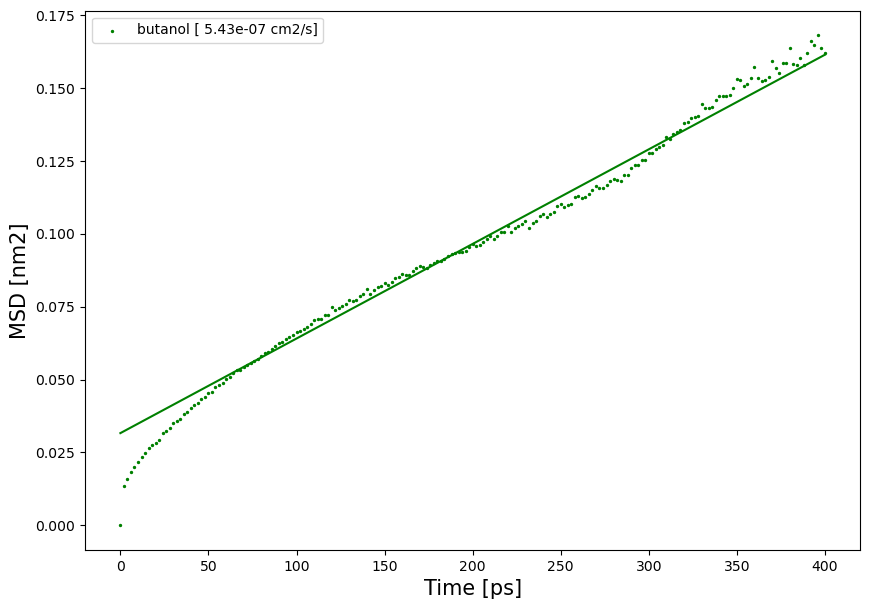

In [8]:
fig, ax = plt.subplots()
ax.set_ylabel('MSD [nm2]')
ax.set_xlabel('Time [ps]')

ax.scatter(
    a.MSD.iloc[:, 0],
    a.MSD.iloc[:, 1],
    label=f'{compound.name:7} [{a.D: 9.2e} cm2/s]',
    c='g',
    s=2,
)
ax.plot(a.MSD.iloc[:, 0], (a.S * a.MSD.iloc[:, 0] + a.S0), 'g')

# time_but = df_but['Time']

# ax.scatter(
#     time_but ,
#     df_but.iloc[:, 1] ,
#     label=f'butanol [{D_but: 9.2f} cm2/day]',
#     c='b',
#     s=2,
# )
# ax.plot(time_but , (S_but * time_but + S0_but) , 'b-')
ax.legend()

# ax.set_title(f"{compound} - {x} butanol :{T} C")
# fig.savefig(f"MSD_old.jpg", dpi=600)

In [3]:
# for directory in get_solve_dir(Path('gromacs/workspace/solvs')):
#     name = r'.traj.xtc_offsets.lock'
#     name2 = r'.traj.xtc_offsets.npz'
#     os.remove(directory / name)
#     os.remove(directory / name2)

## loop

In [14]:
solves_path=Path('gromacs/workspace/solvs')
plots_path=Path('gromacs/workspace/plots')

Reading file gromacs/workspace/solvs/butanol_100_700/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/butanol_100_700/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  3000 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  3000 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.2219 (+/- 0.0171) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/butanol_100_700/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/butanol_100_700/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  3000 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  3000 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.2219 (+/- 0.0171) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/butanol_100_700/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/butanol_100_700/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  3000 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  3000 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.2871 (+/- 0.0168) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/butanol_100_700/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/butanol_100_700/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  3000 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  3000 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.2871 (+/- 0.0168) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/butanol_100_700/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/butanol_100_700/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  3000 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  3000 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.3020 (+/- 0.0380) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/butanol_100_700/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/butanol_100_700/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  3000 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  3000 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.3020 (+/- 0.0380) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/butanol_100_700/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/butanol_100_700/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  3000 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  3000 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.3303 (+/- 0.0097) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/butanol_100_700/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/butanol_100_700/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/butanol_100_700/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  3000 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  3000 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.3303 (+/- 0.0097) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_0_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_0_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_0_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_0_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  5600 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  5600 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0783 (+/- 0.0122) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_0_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_0_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_0_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_0_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  5600 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  5600 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.1068 (+/- 0.0119) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_0_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_0_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_0_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_0_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  5600 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  5600 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0873 (+/- 0.0201) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_0_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_0_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_0_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_0_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  5600 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  5600 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.1002 (+/- 0.0099) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_11_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_11_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  4984 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  4984 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0548 (+/- 0.0054) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_11_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_11_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   330 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   330 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.0731 (+/- 0.0252) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_11_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_11_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  4984 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  4984 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0833 (+/- 0.0071) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_11_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_11_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   330 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   330 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1551 (+/- 0.0330) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_11_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_11_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  4984 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  4984 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0591 (+/- 0.0187) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_11_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_11_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   330 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   330 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.0756 (+/- 0.0122) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_11_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_11_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  4984 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  4984 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0921 (+/- 0.0100) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_11_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_11_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_11_1069/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   330 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   330 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1325 (+/- 0.0403) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_22_1050/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_22_1050/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  4368 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  4368 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0853 (+/- 0.0116) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_22_1050/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_22_1050/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   660 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   660 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1069 (+/- 0.0351) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_22_1050/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_22_1050/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  4368 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  4368 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.1049 (+/- 0.0141) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_22_1050/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_22_1050/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   660 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   660 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1072 (+/- 0.0544) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_22_1050/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_22_1050/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  4368 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  4368 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0987 (+/- 0.0208) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_22_1050/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_22_1050/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   660 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   660 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1416 (+/- 0.0405) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_22_1050/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_22_1050/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  4368 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  4368 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.1374 (+/- 0.0034) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_22_1050/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_22_1050/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_22_1050/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   660 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   660 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1908 (+/- 0.0099) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_35_1029/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_35_1029/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  3640 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  3640 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0553 (+/- 0.0097) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_35_1029/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_35_1029/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1050 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1050 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.0822 (+/- 0.0175) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_35_1029/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_35_1029/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  3640 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  3640 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0893 (+/- 0.0189) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_35_1029/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_35_1029/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1050 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1050 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1169 (+/- 0.0344) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_35_1029/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_35_1029/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  3640 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  3640 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0516 (+/- 0.0023) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_35_1029/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_35_1029/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1050 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1050 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.0996 (+/- 0.0022) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_35_1029/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_35_1029/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  3640 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  3640 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.1096 (+/- 0.0092) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_35_1029/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_35_1029/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_35_1029/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1050 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1050 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1465 (+/- 0.0068) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_39_1019/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_39_1019/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  3416 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  3416 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0912 (+/- 0.0030) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_39_1019/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_39_1019/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1170 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1170 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1079 (+/- 0.0035) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_39_1019/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_39_1019/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  3416 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  3416 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0738 (+/- 0.0009) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_39_1019/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_39_1019/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1170 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1170 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1061 (+/- 0.0075) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_39_1019/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_39_1019/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  3416 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  3416 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.0570 (+/- 0.0209) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_39_1019/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_39_1019/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1170 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1170 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1090 (+/- 0.0232) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_39_1019/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_39_1019/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  3416 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            DMA) has  3416 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       DMA] 0.1012 (+/- 0.0089) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/dmag_39_1019/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/dmag_39_1019/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/dmag_39_1019/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1170 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1170 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.1570 (+/- 0.0322) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_0_1200/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_0_1200/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_0_1200/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_0_1200/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  7800 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  7800 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.2579 (+/- 0.0295) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_0_1200/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_0_1200/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_0_1200/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_0_1200/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  7800 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  7800 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.2283 (+/- 0.0519) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_0_1200/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_0_1200/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_0_1200/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_0_1200/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  7800 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  7800 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.2262 (+/- 0.0052) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_0_1200/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_0_1200/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_0_1200/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_0_1200/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  7800 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  7800 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.2584 (+/- 0.0513) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_19_1180/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_19_1180/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  6318 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  6318 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.2296 (+/- 0.0401) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_19_1180/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_19_1180/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   570 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   570 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.7317 (+/- 0.0548) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_19_1180/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_19_1180/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  6318 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  6318 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.2156 (+/- 0.0292) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_19_1180/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_19_1180/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   570 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   570 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.5453 (+/- 0.2235) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_19_1180/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_19_1180/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  6318 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  6318 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1886 (+/- 0.0561) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_19_1180/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_19_1180/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   570 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   570 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.4751 (+/- 0.0759) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_19_1180/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_19_1180/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  6318 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  6318 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1759 (+/- 0.0202) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_19_1180/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_19_1180/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_19_1180/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   570 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   570 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.5073 (+/- 0.0717) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_30_1159/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_30_1159/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  5460 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  5460 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1113 (+/- 0.0051) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_30_1159/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_30_1159/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   900 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   900 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.3126 (+/- 0.0381) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_30_1159/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_30_1159/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  5460 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  5460 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1555 (+/- 0.0175) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_30_1159/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_30_1159/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   900 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   900 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.4638 (+/- 0.0290) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_30_1159/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_30_1159/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  5460 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  5460 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1323 (+/- 0.0159) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_30_1159/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_30_1159/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   900 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   900 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.3344 (+/- 0.0265) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_30_1159/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_30_1159/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  5460 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  5460 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1160 (+/- 0.0276) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_30_1159/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_30_1159/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_30_1159/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has   900 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has   900 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.3910 (+/- 0.0211) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_41_1140/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_41_1140/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  4602 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  4602 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.0855 (+/- 0.0248) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_41_1140/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_41_1140/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1230 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1230 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.2730 (+/- 0.0299) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_41_1140/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_41_1140/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  4602 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  4602 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1313 (+/- 0.0038) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_41_1140/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_41_1140/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1230 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1230 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.3920 (+/- 0.0198) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_41_1140/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_41_1140/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  4602 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  4602 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1244 (+/- 0.0394) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_41_1140/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_41_1140/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1230 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1230 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.2706 (+/- 0.0891) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_41_1140/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_41_1140/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  4602 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  4602 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1024 (+/- 0.0096) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_41_1140/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_41_1140/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_41_1140/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1230 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1230 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.2640 (+/- 0.0445) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_49_1110/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_49_1110/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  3978 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  3978 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.0948 (+/- 0.0353) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_49_1110/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_49_1110/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/15/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1470 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1470 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.2170 (+/- 0.0523) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_49_1110/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_49_1110/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  3978 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  3978 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1144 (+/- 0.0117) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_49_1110/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_49_1110/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/20/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1470 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1470 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.2803 (+/- 0.0455) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_49_1110/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_49_1110/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  3978 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  3978 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1395 (+/- 0.0087) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_49_1110/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_49_1110/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/25/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1470 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1470 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.3763 (+/- 0.0891) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_49_1110/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_49_1110/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  3978 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            PET) has  3978 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       PET] 0.1295 (+/- 0.0200) 1e-5 cm^2/s


Reading file gromacs/workspace/solvs/peta_49_1110/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/peta_49_1110/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/peta_49_1110/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1470 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1470 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 50 to 300 ps

D[       BUT] 0.3221 (+/- 0.0240) 1e-5 cm^2/s


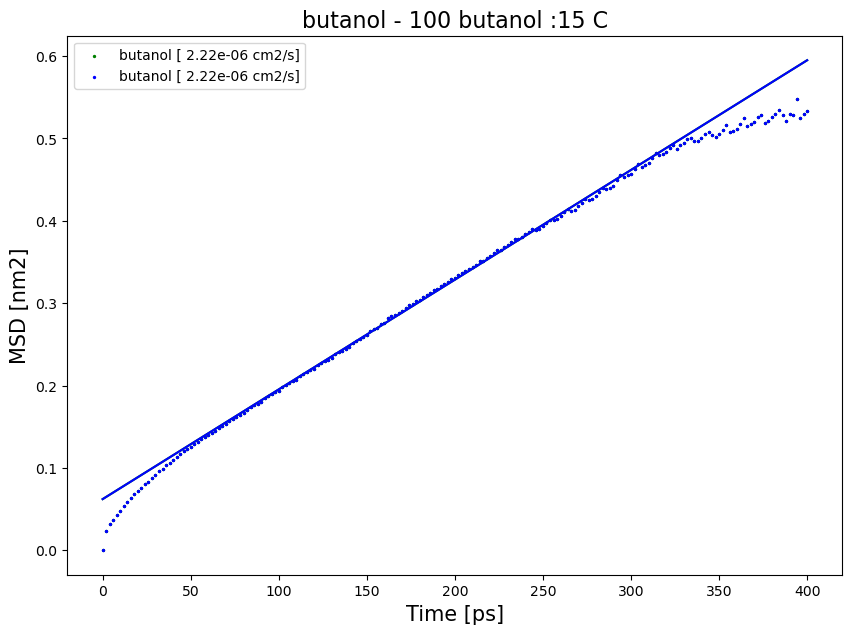

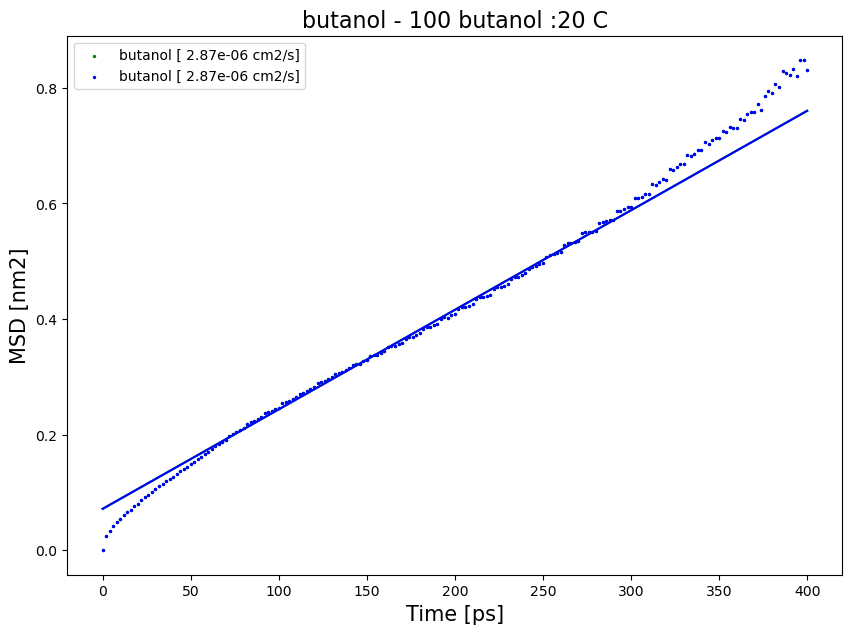

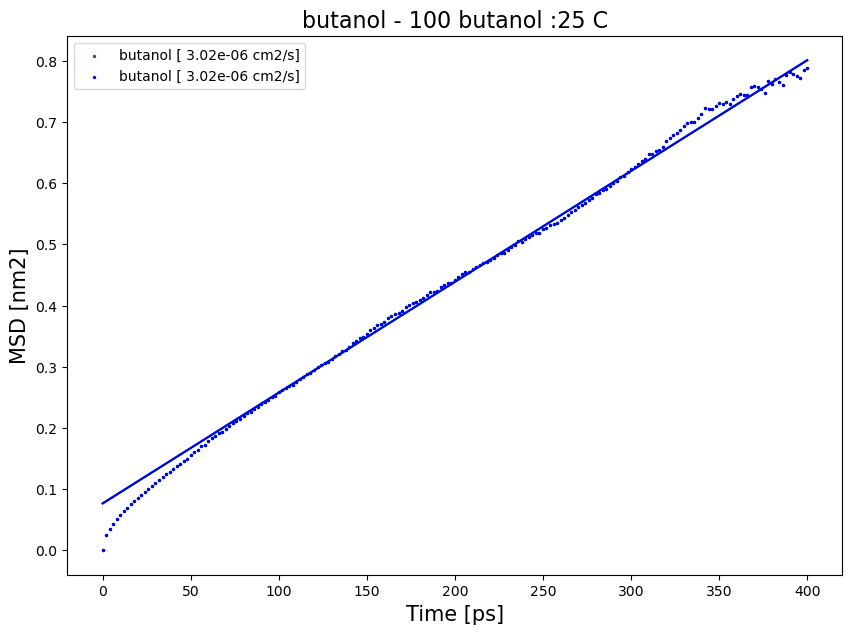

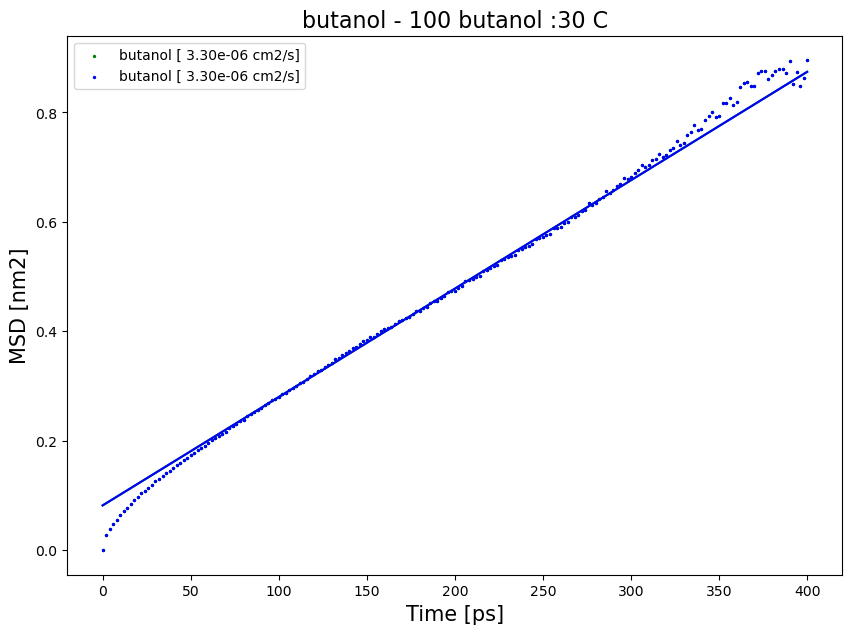

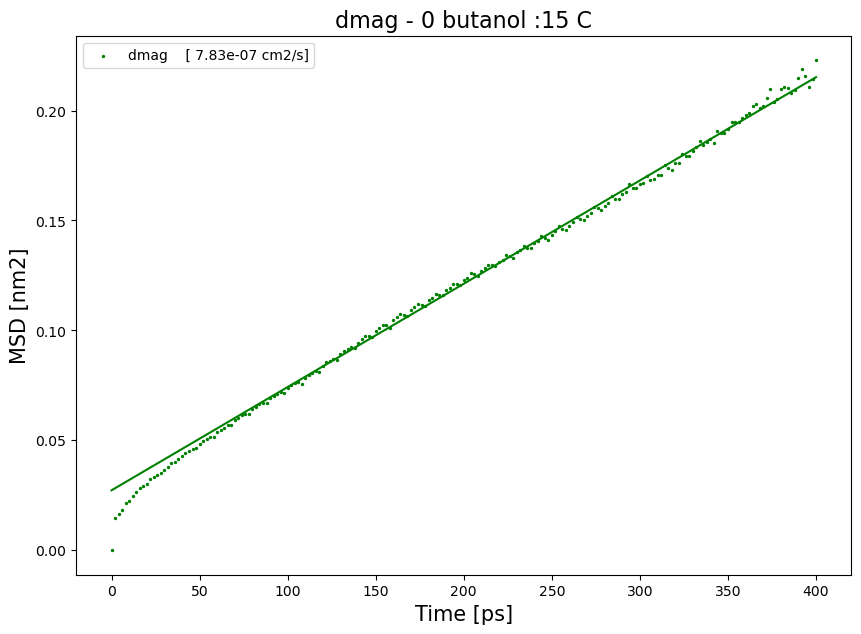

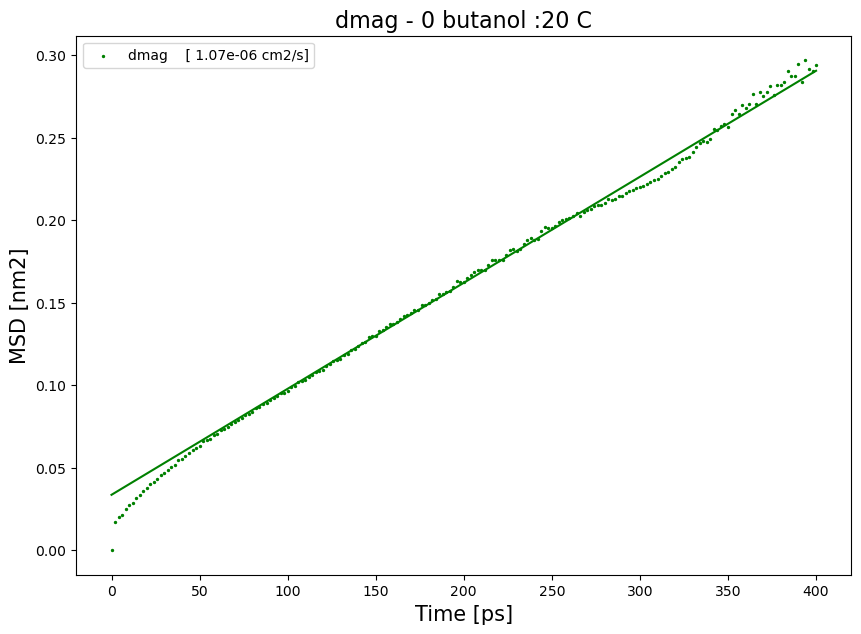

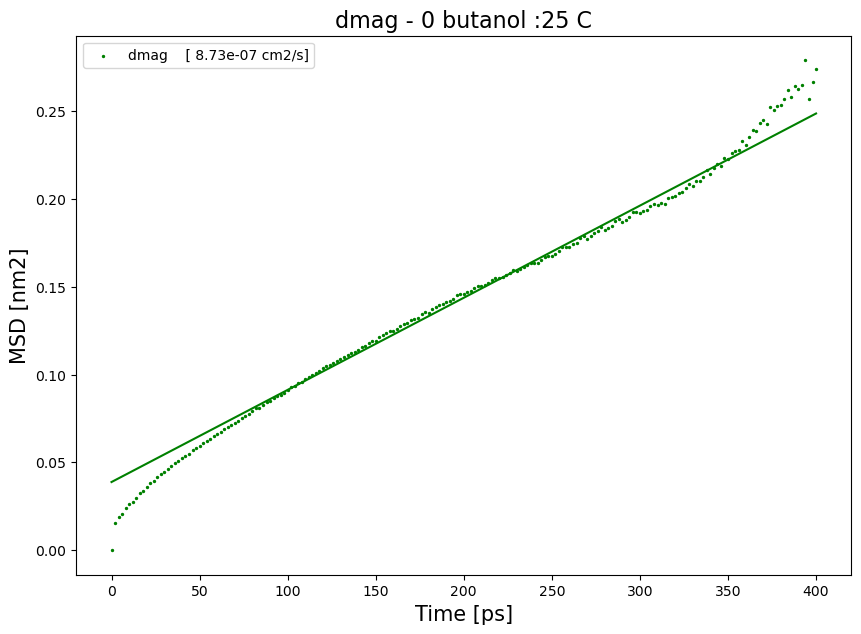

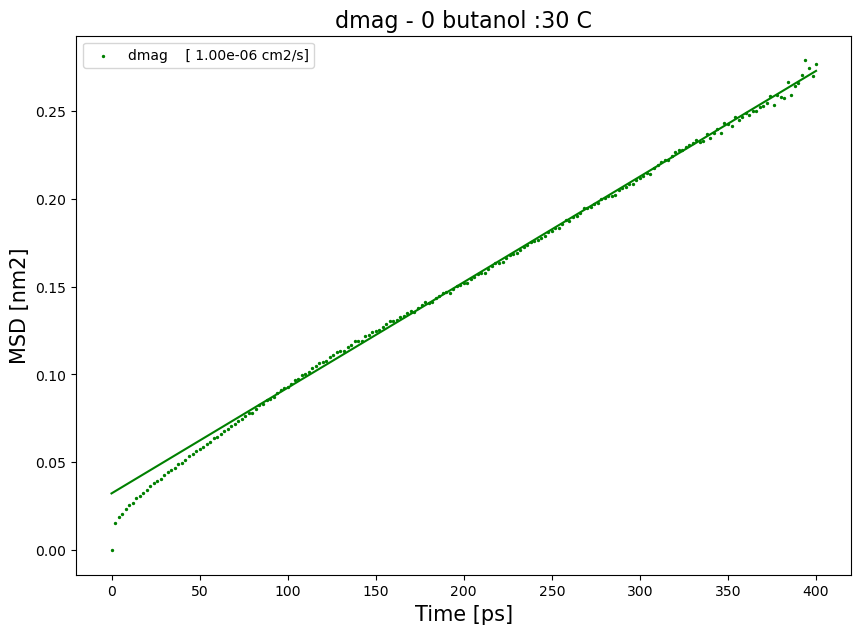

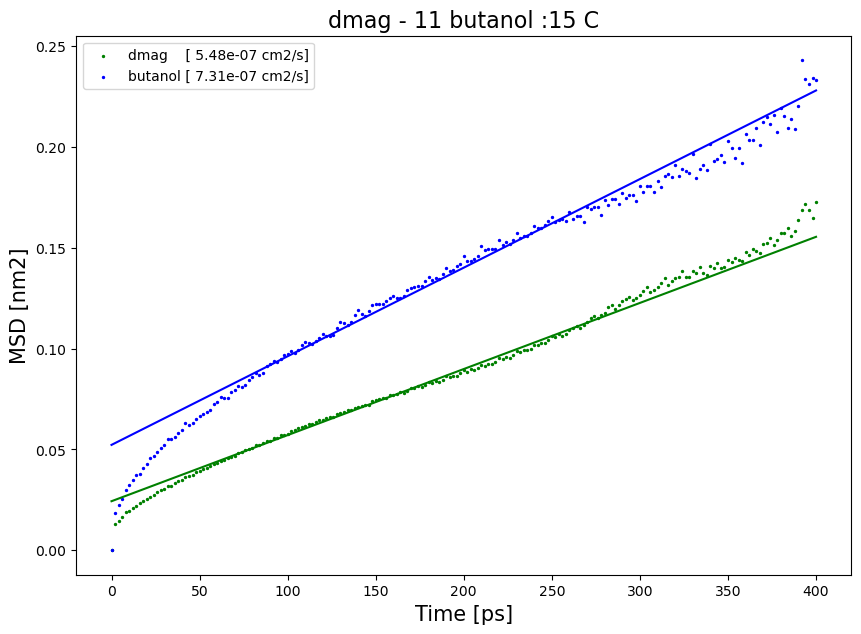

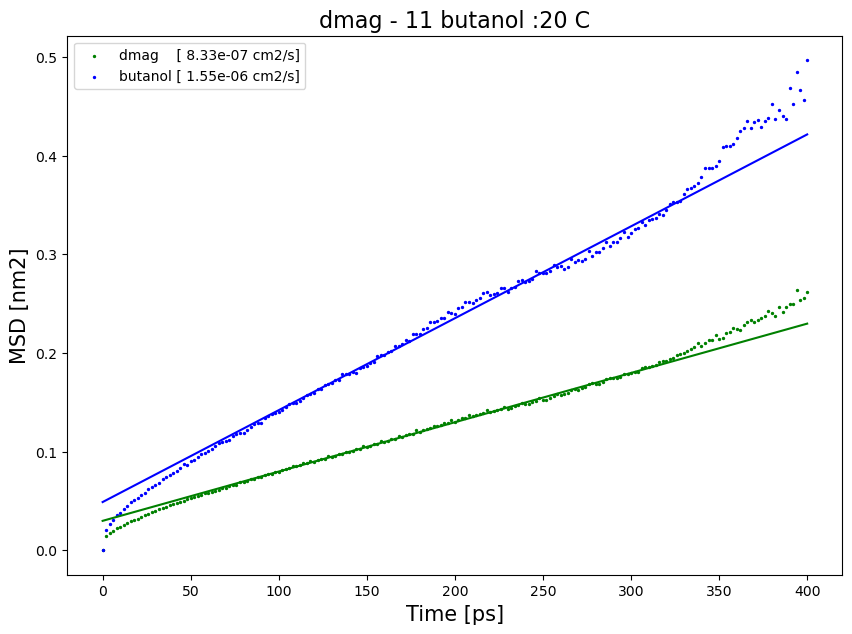

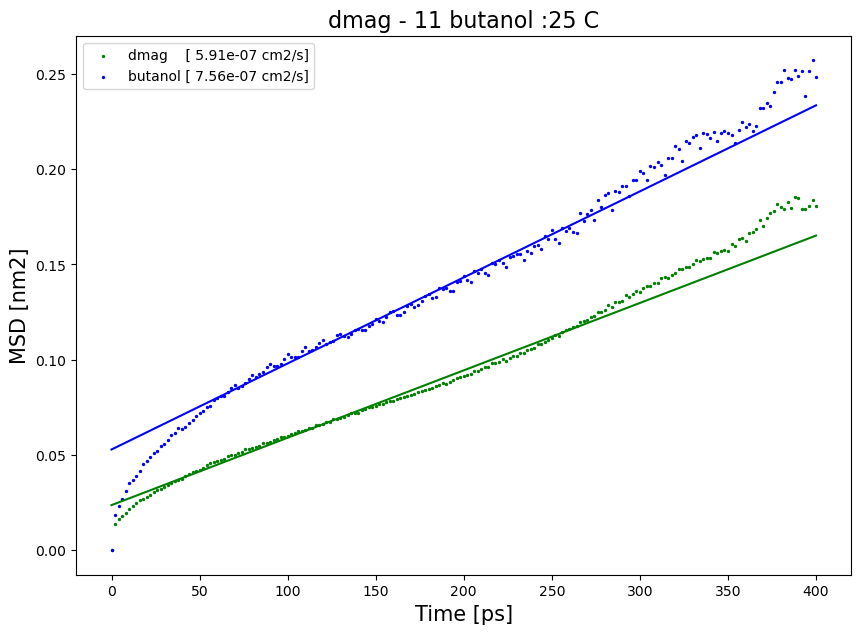

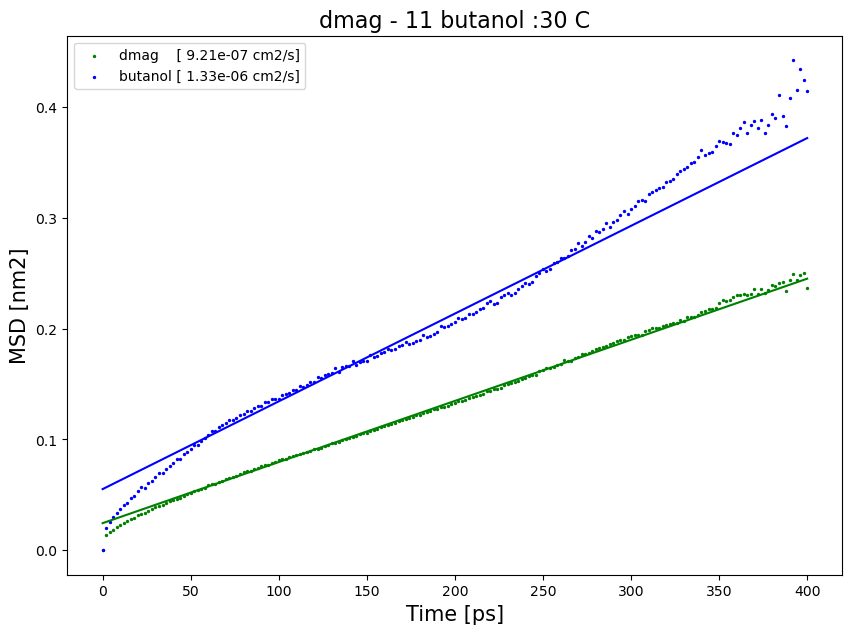

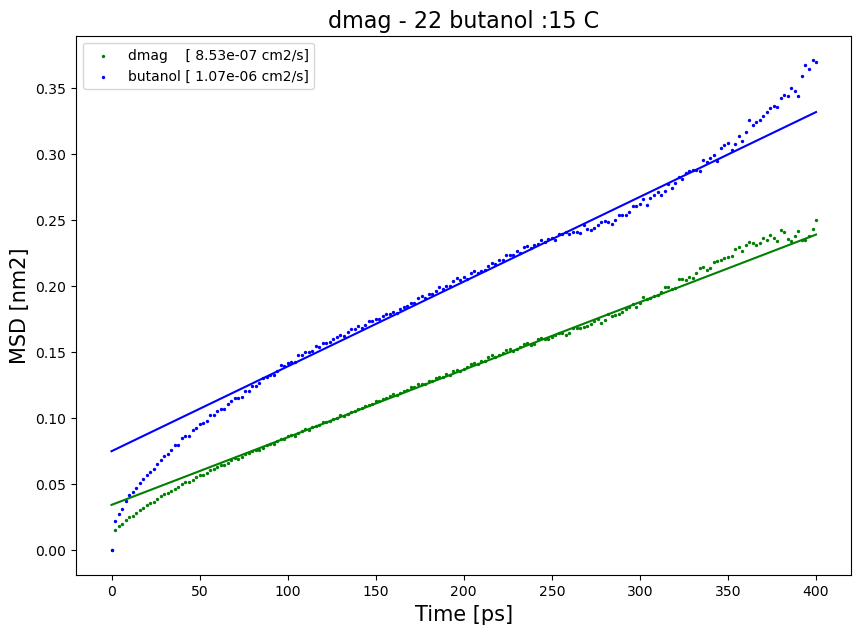

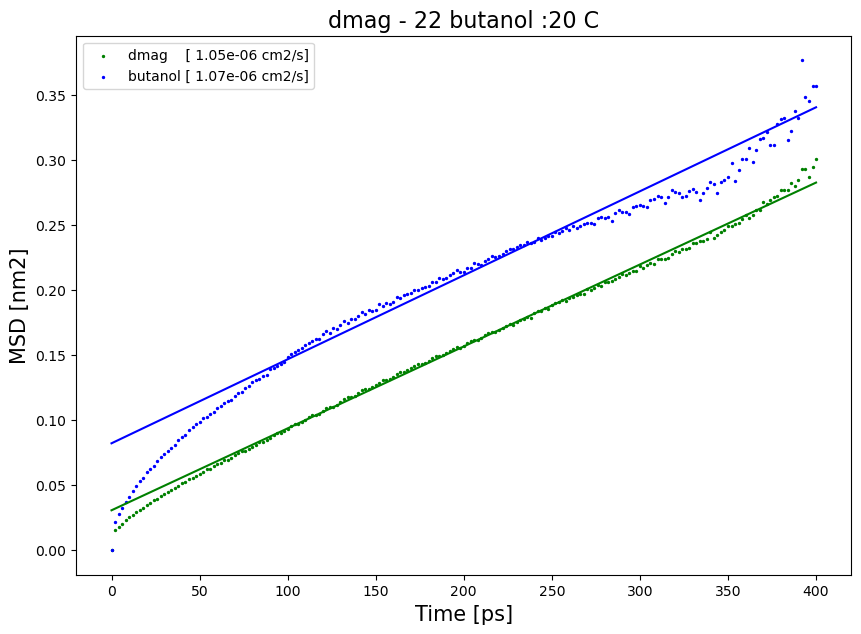

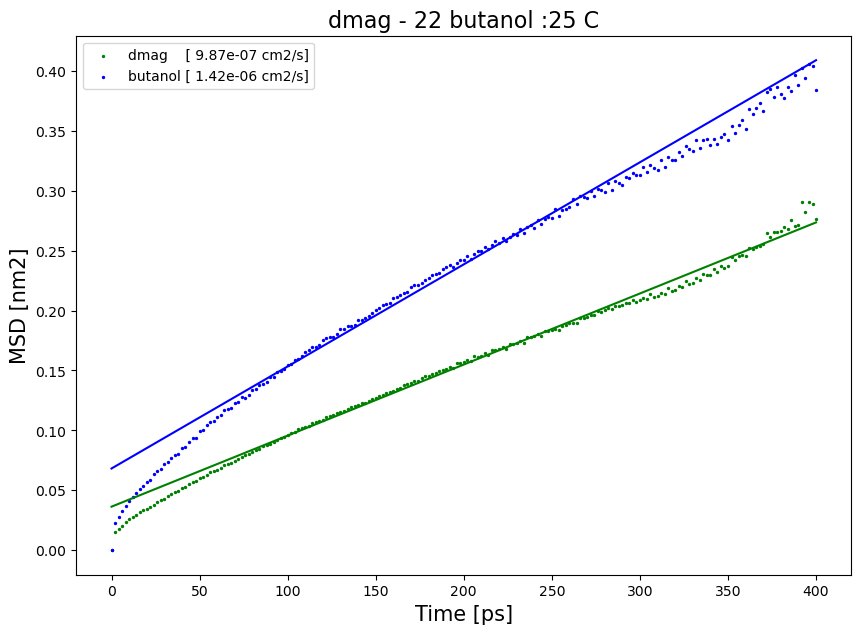

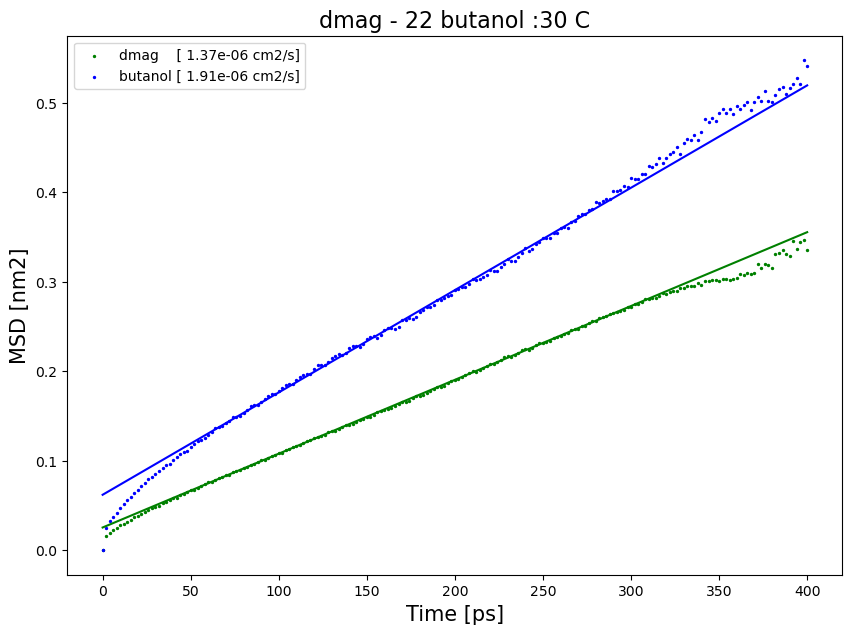

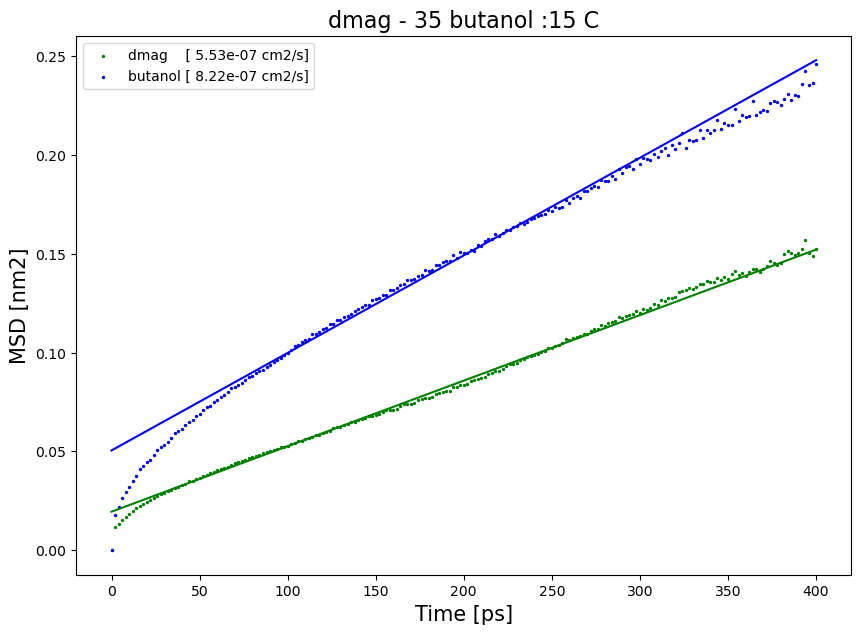

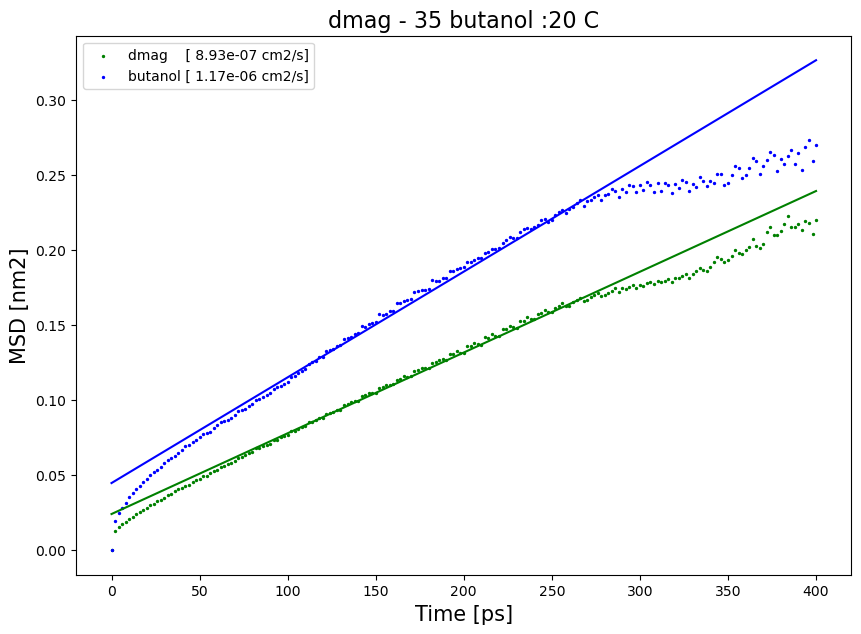

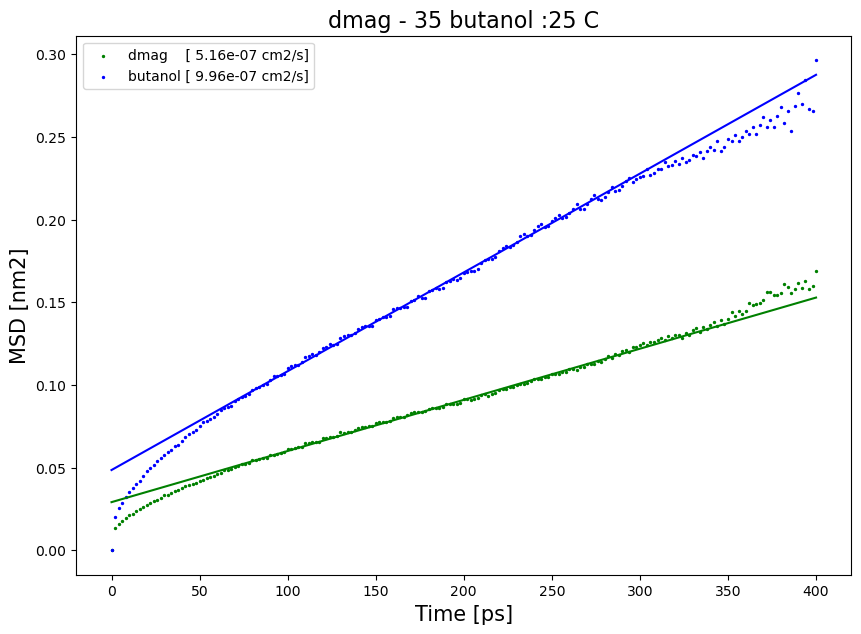

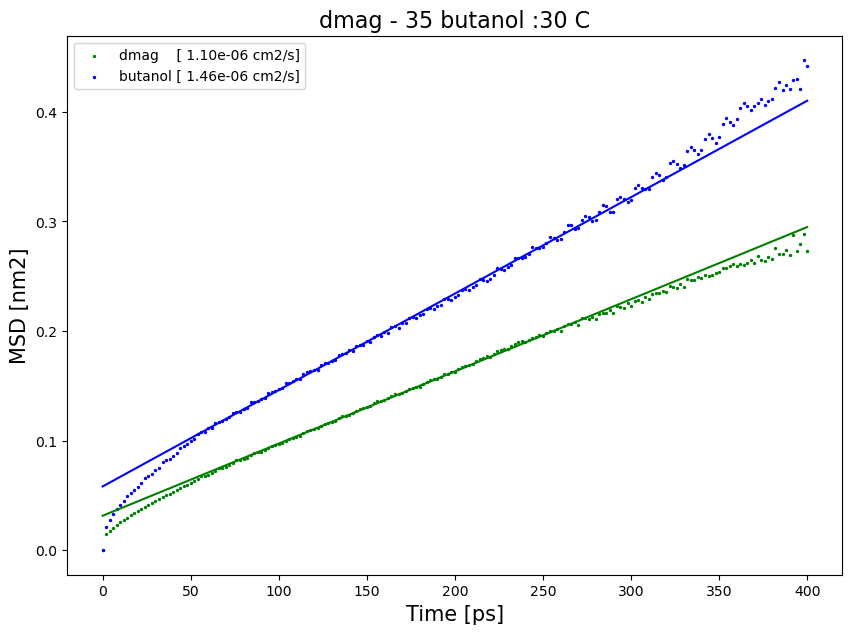

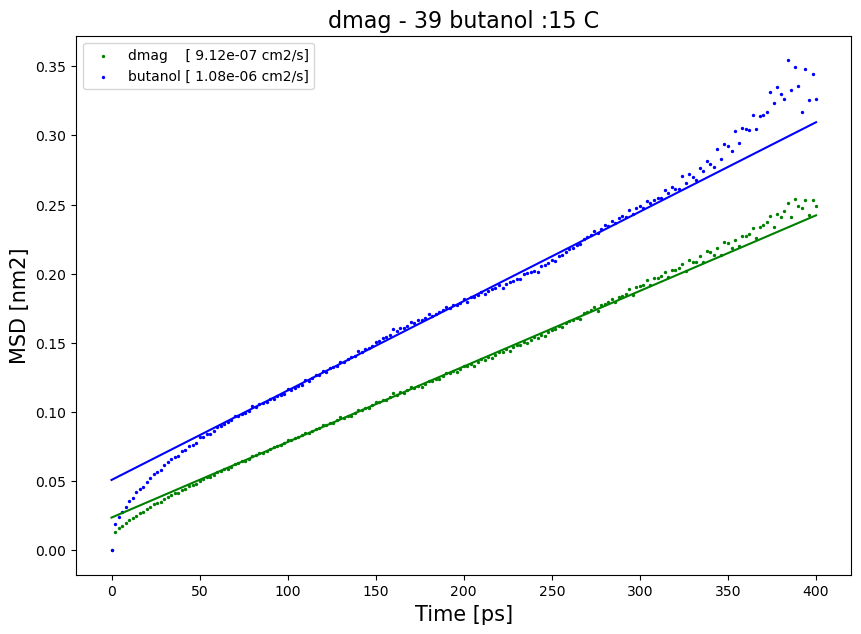

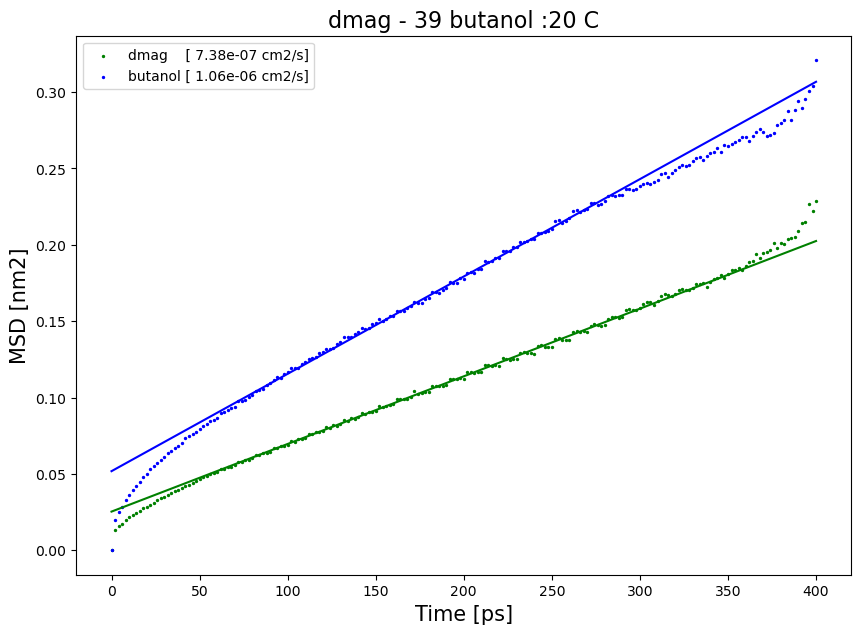

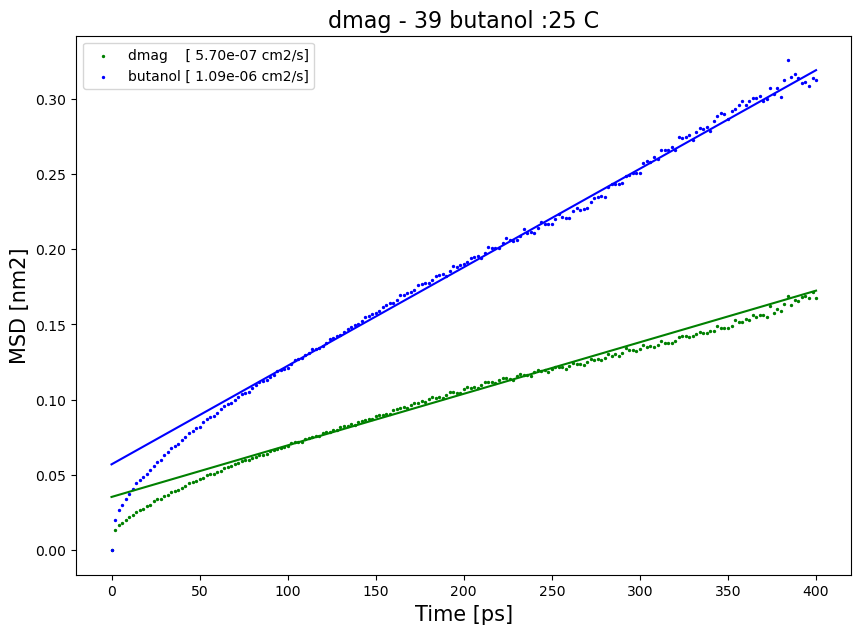

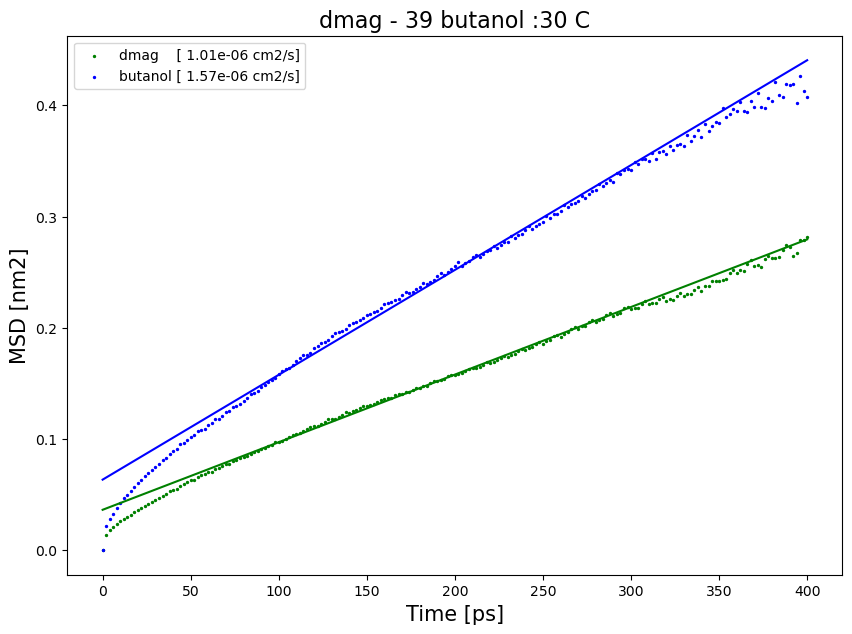

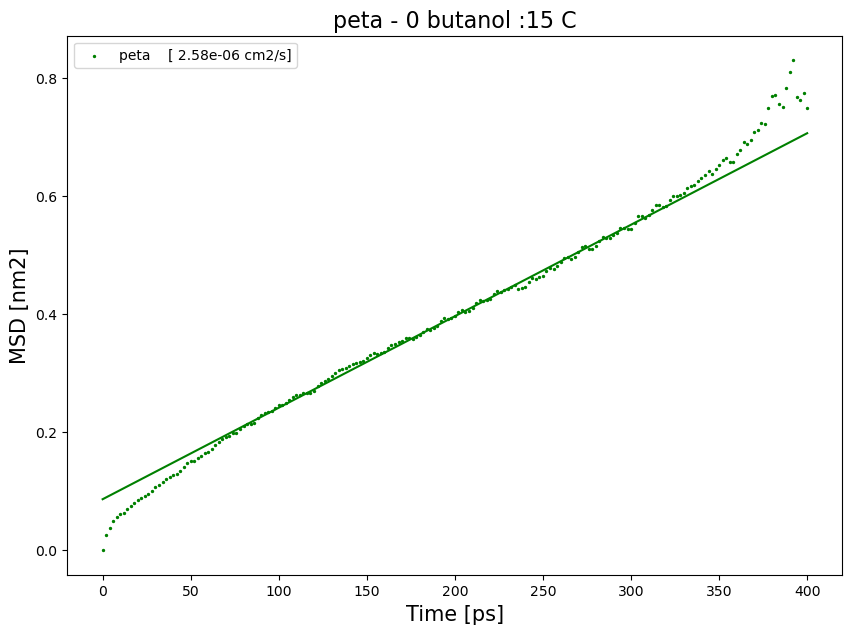

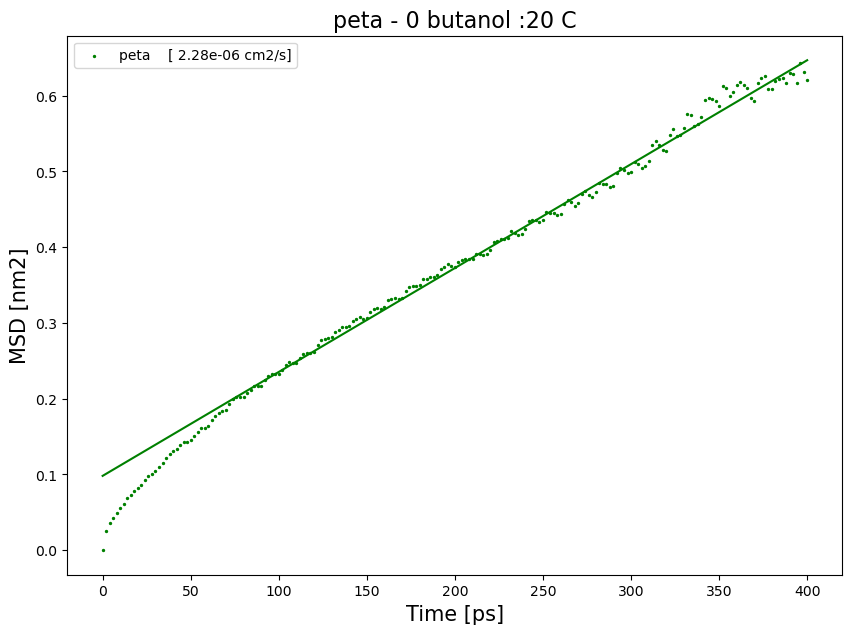

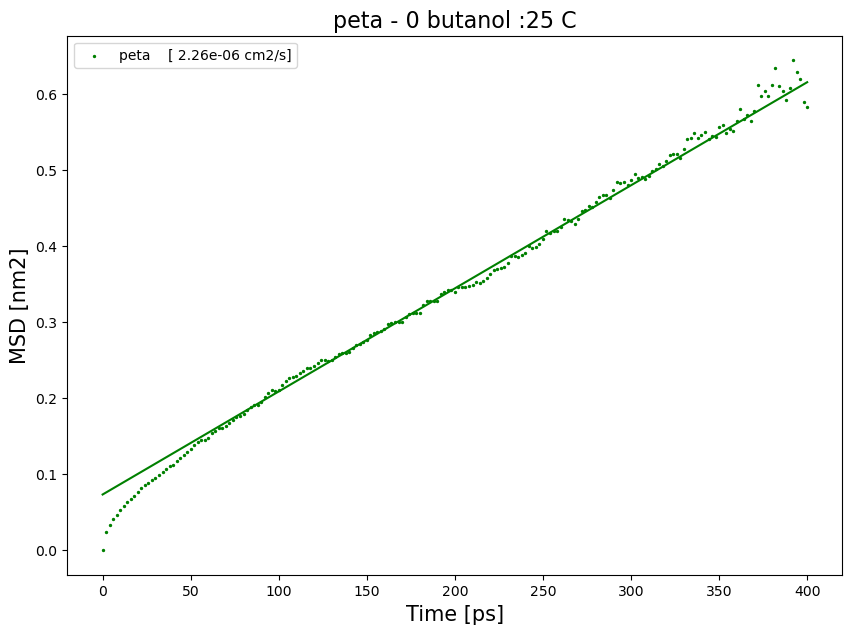

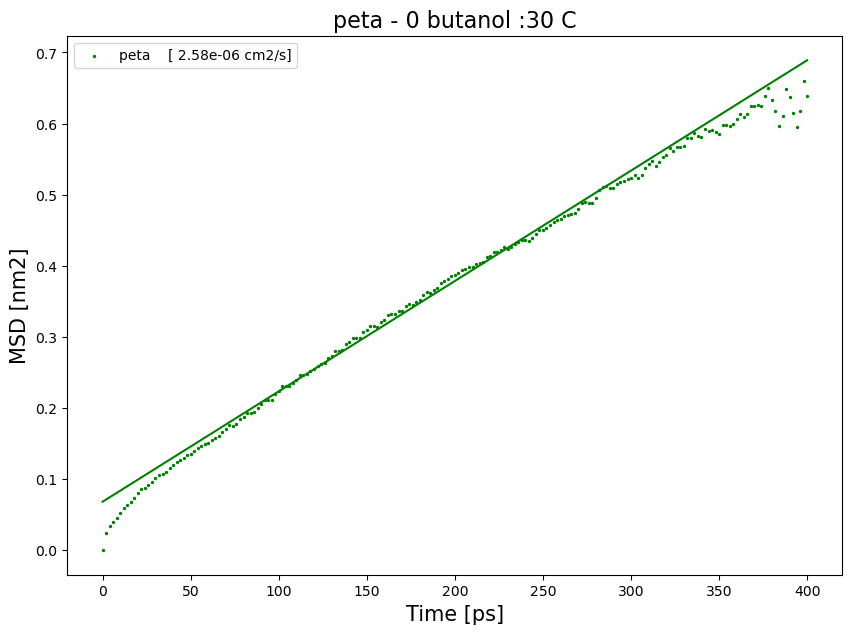

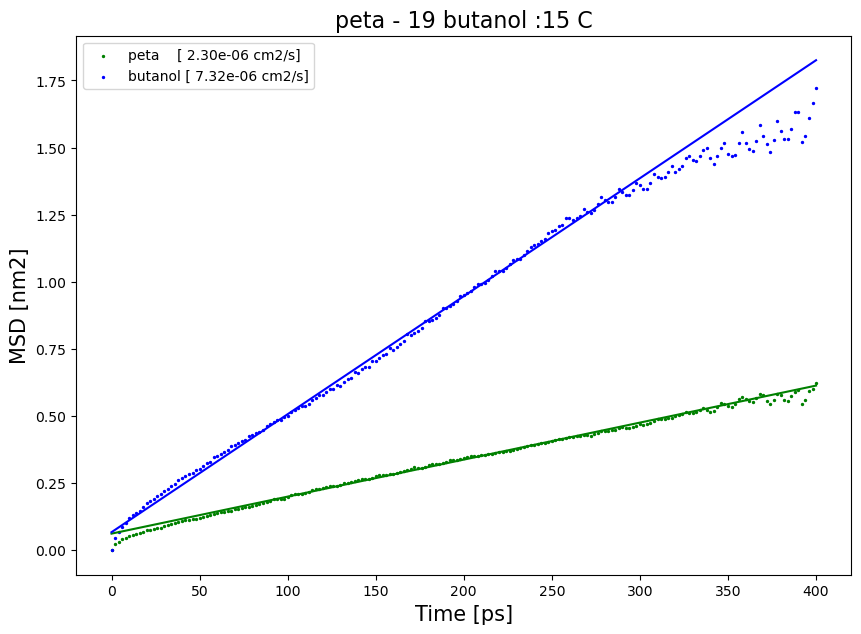

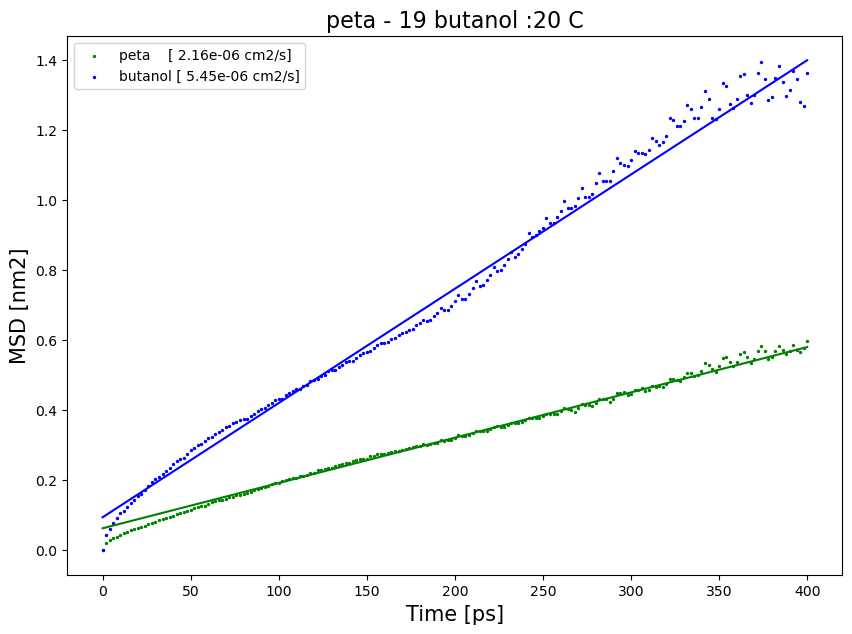

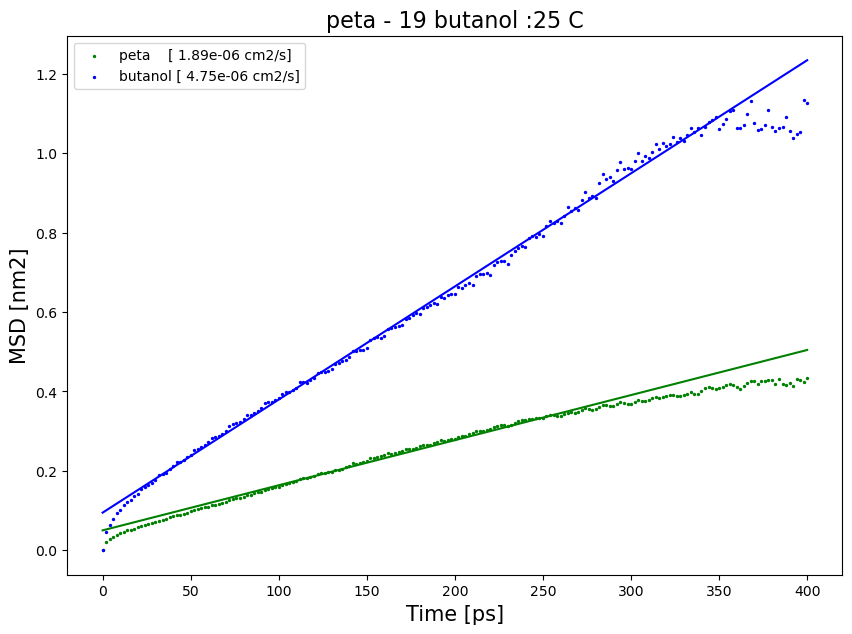

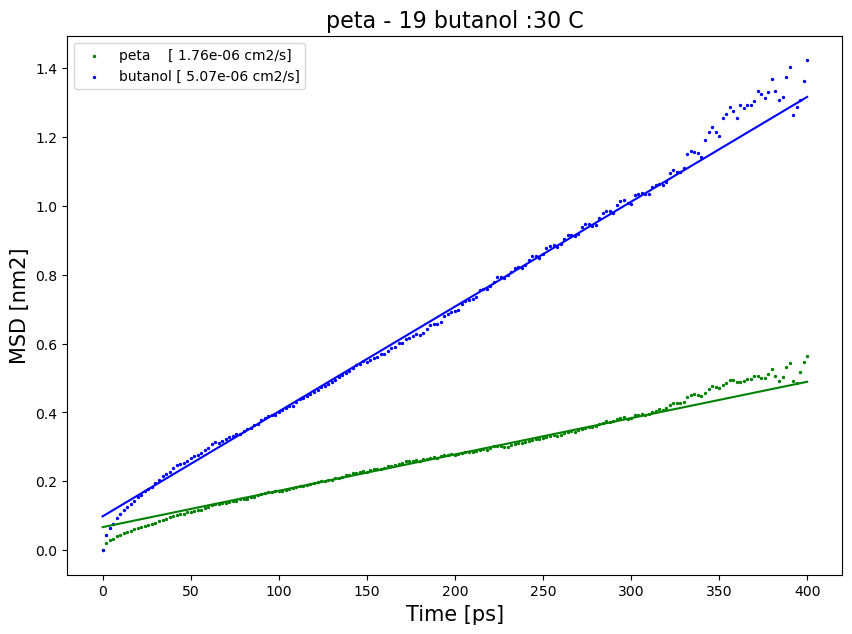

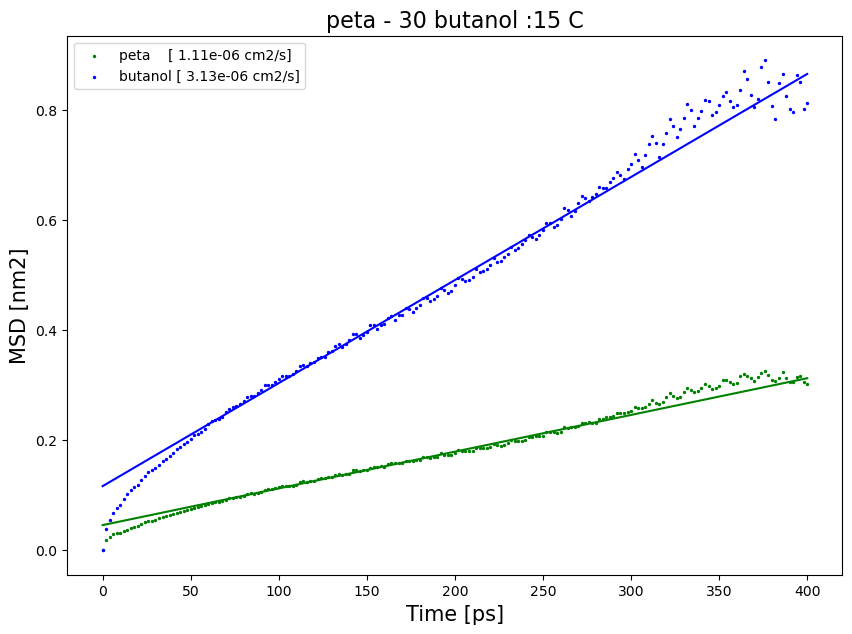

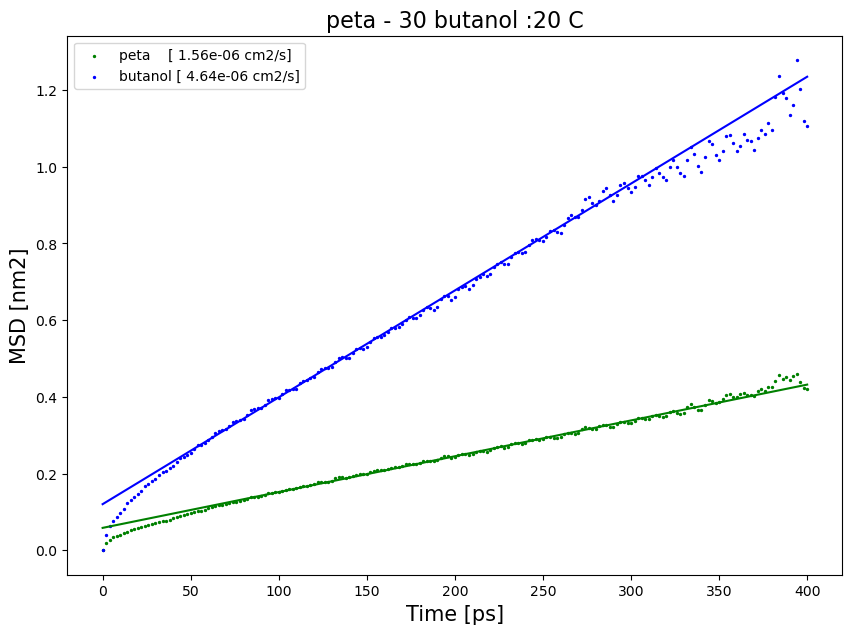

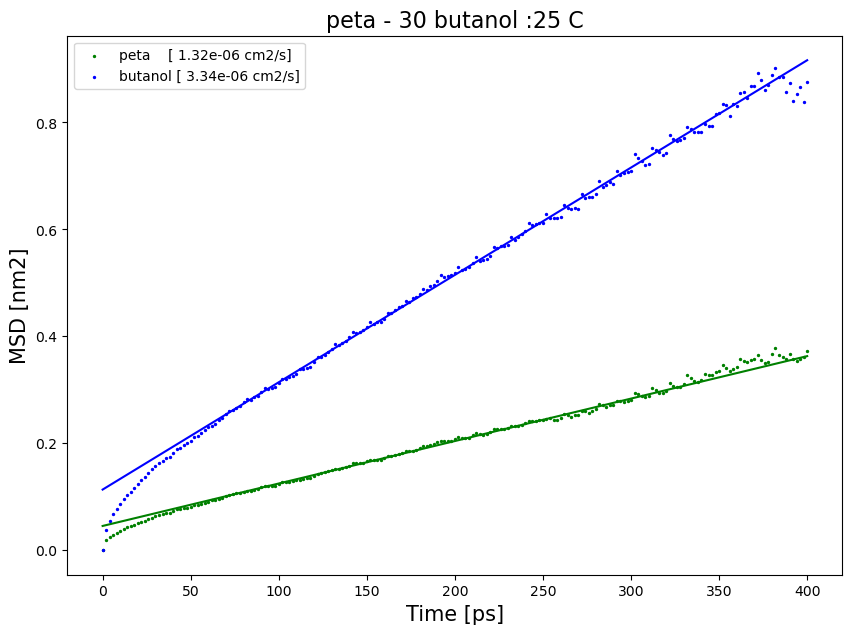

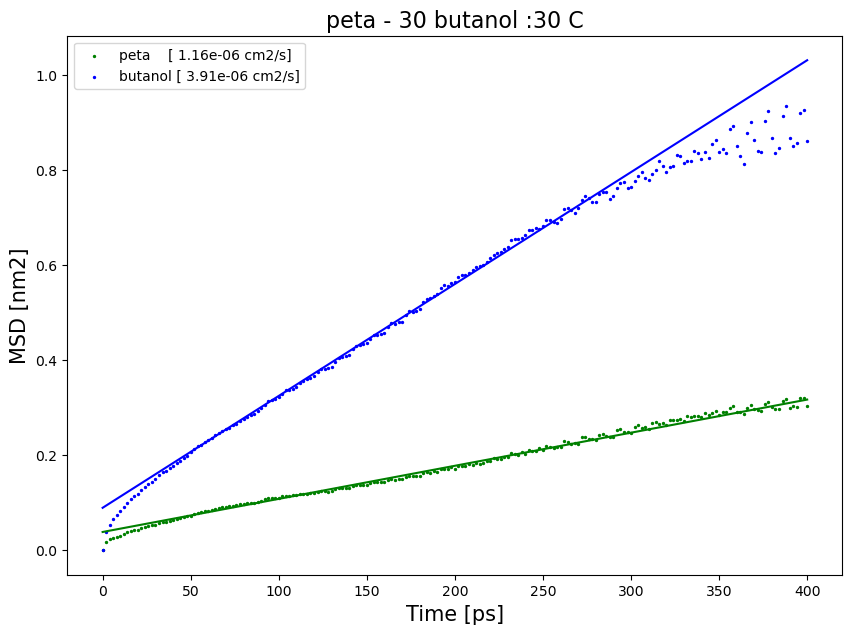

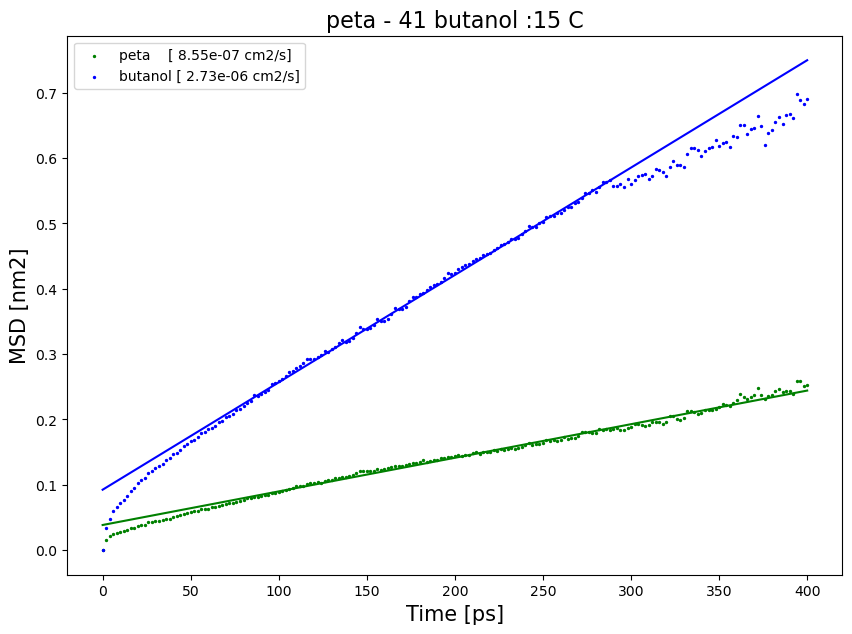

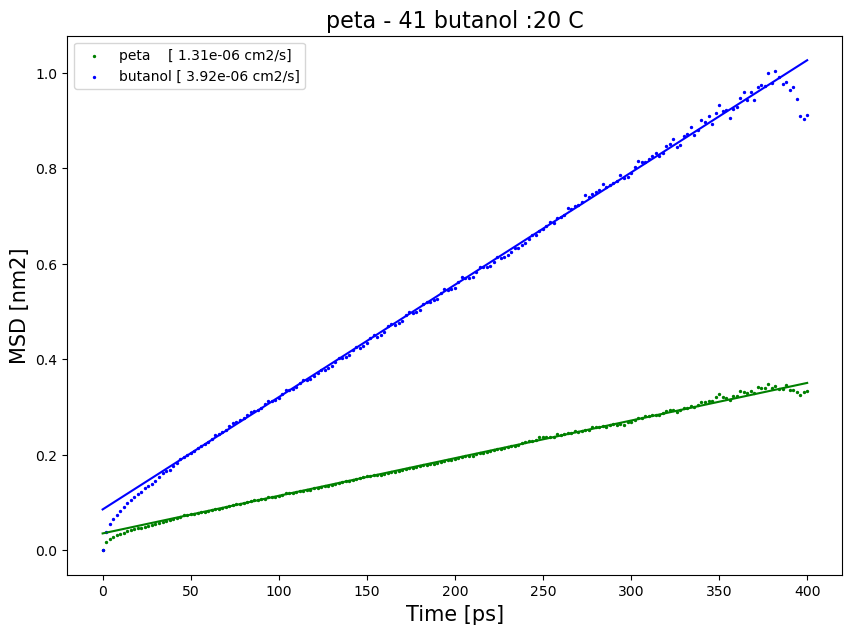

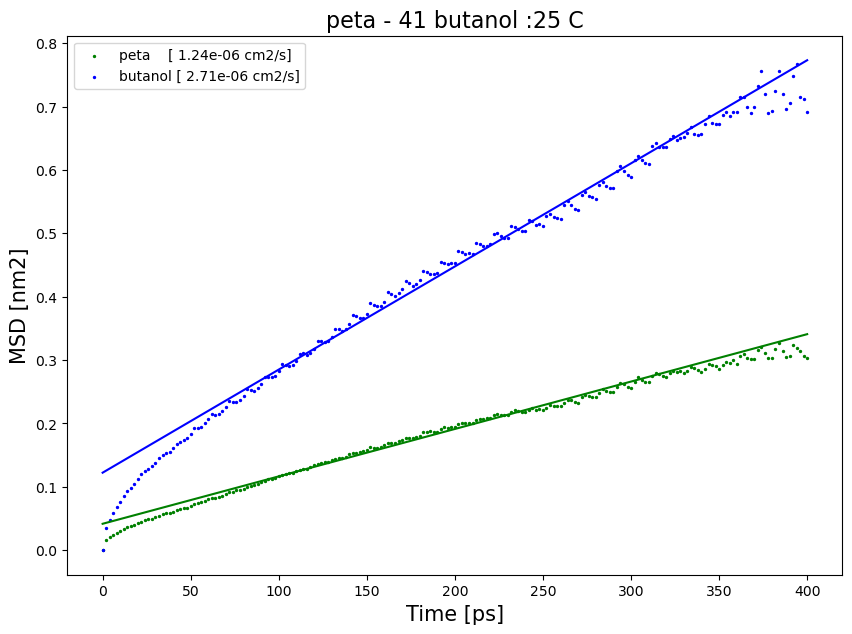

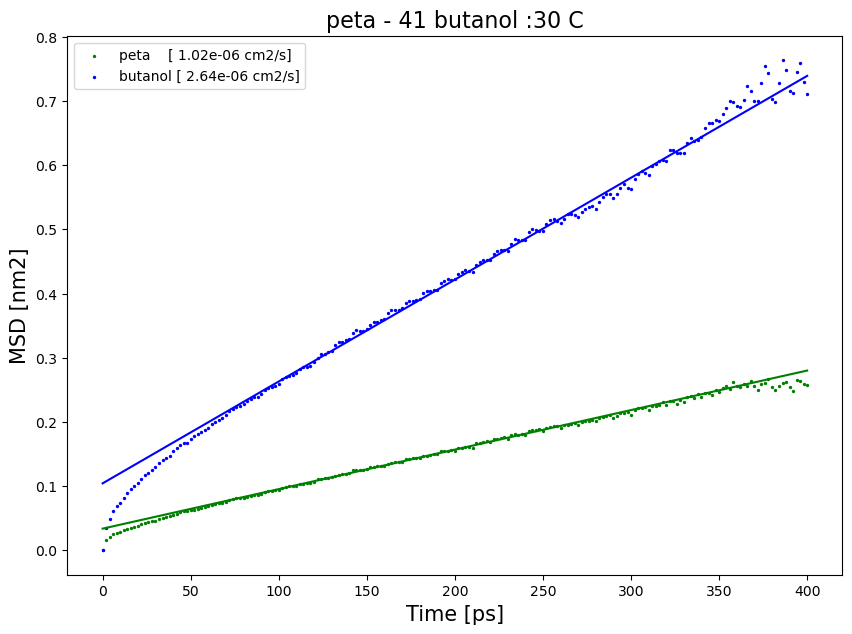

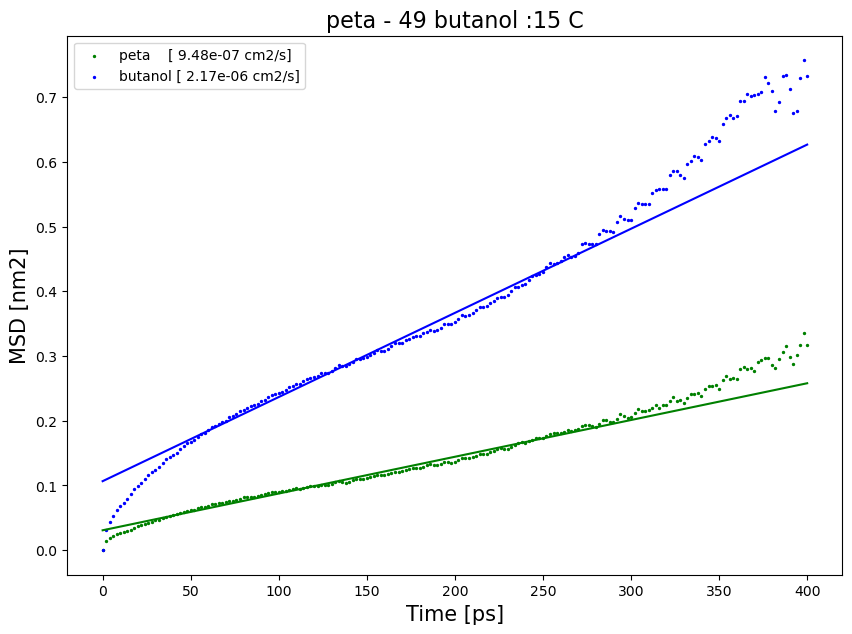

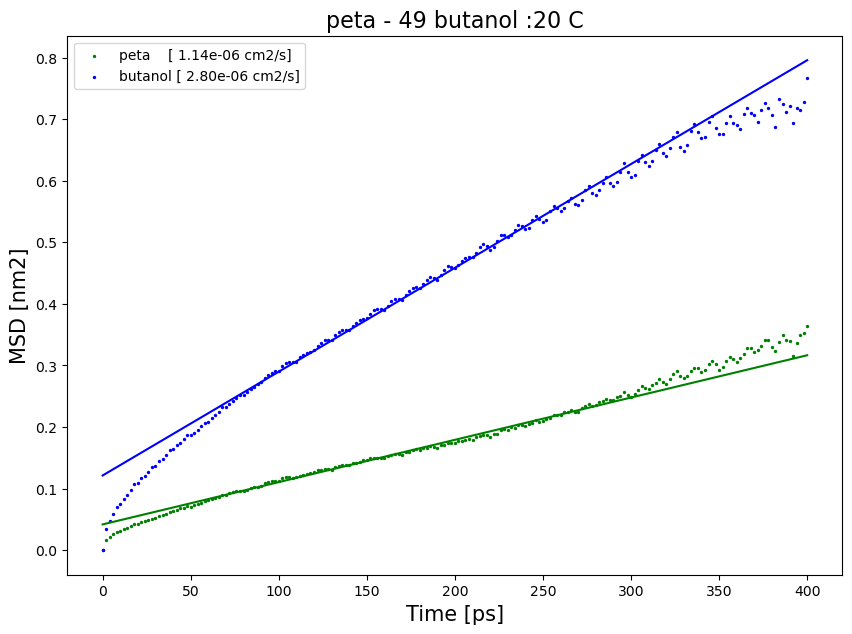

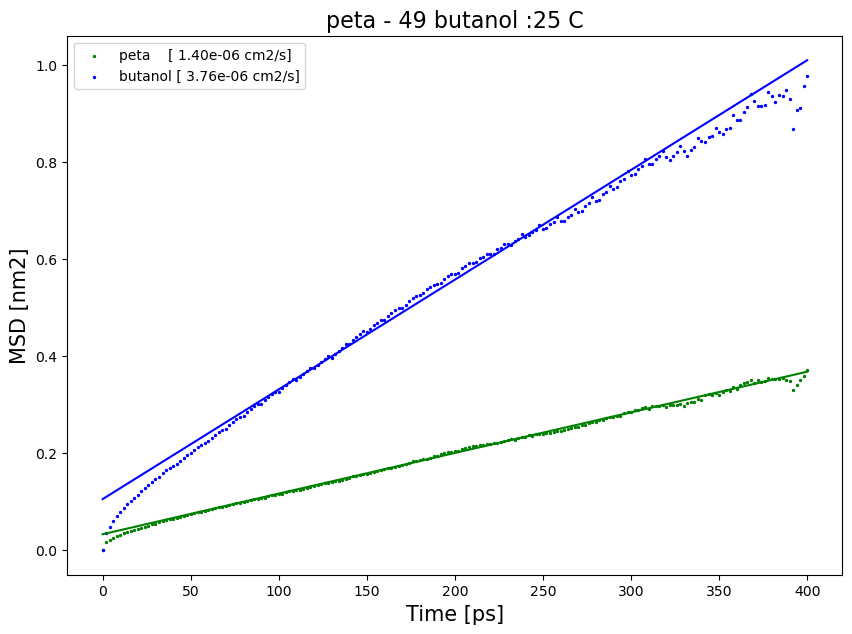

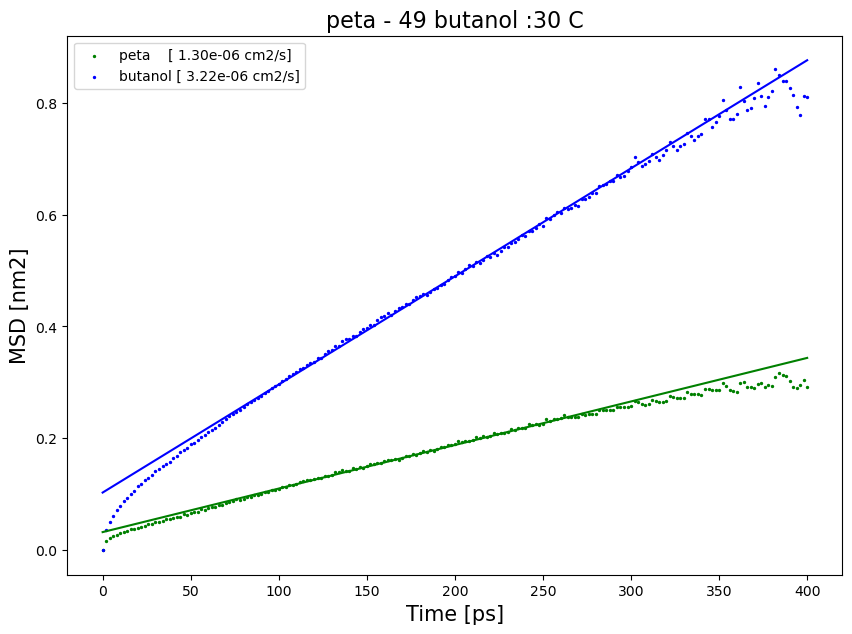

In [15]:
i = 0
datas = []
Rs = []
for directory in get_solve_dir(solves_path):
    if 'ocm' in str(directory):
        continue
    compound, x, rho = directory.parent.stem.split('_')
    T = directory.stem
    compound = Mols[compound]

    system = directory / '5MD/system.tpr'
    traj = directory / '5MD/md.xtc'

    comp = D_results(compound)
    comp.get_MSD_gmx(system=system, traj=traj)
    but = D_results(Mols.butanol)
    if x != '0':
        but.get_MSD_gmx(system=system, traj=traj)

    #
    fig, ax = plt.subplots()
    ax.set_title(f"{compound.name} - {x} butanol :{T} C")
    ax.set_ylabel('MSD [nm2]')
    ax.set_xlabel('Time [ps]')

    ax.scatter(
        comp.MSD.iloc[:, 0],
        comp.MSD.iloc[:, 1],
        label=f'{compound.name:7} [{comp.D: 9.2e} cm2/s]',
        c='g',
        s=2,
    )
    ax.plot(comp.MSD.iloc[:, 0], (comp.S * comp.MSD.iloc[:, 0] + comp.S0), 'g')

    if x != '0':
        ax.scatter(
            but.MSD.iloc[:, 0],
            but.MSD.iloc[:, 1],
            label=f'{Mols.butanol.name:7} [{but.D: 9.2e} cm2/s]',
            c='b',
            s=2,
        )
        ax.plot(but.MSD.iloc[:, 0], (but.S * but.MSD.iloc[:, 0] + but.S0), 'b')
    ax.legend()
    plots_path.mkdir(parents=True, exist_ok=True)
    fig.savefig(plots_path / f"{compound.name}_{x}_{T}.jpg", dpi=600)
    Rs.append((comp, but))
    datas.append(
        {
            'compound': compound.name,
            'x': int(x),
            'Temperature': int(T),
            'D_comp': comp.D,
            'D_but': but.D,
        }
    )
D_df = pd.DataFrame(datas)
D_df.to_csv(Path(plots_path).parent / 'res.csv')

# D analyse

In [17]:
D_df = pd.read_csv('gromacs/workspace/res.csv')

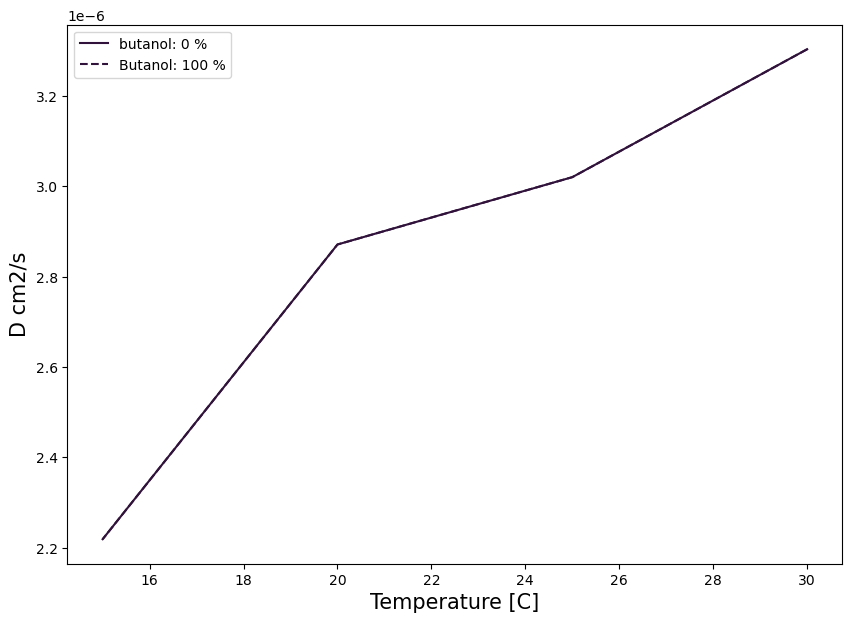

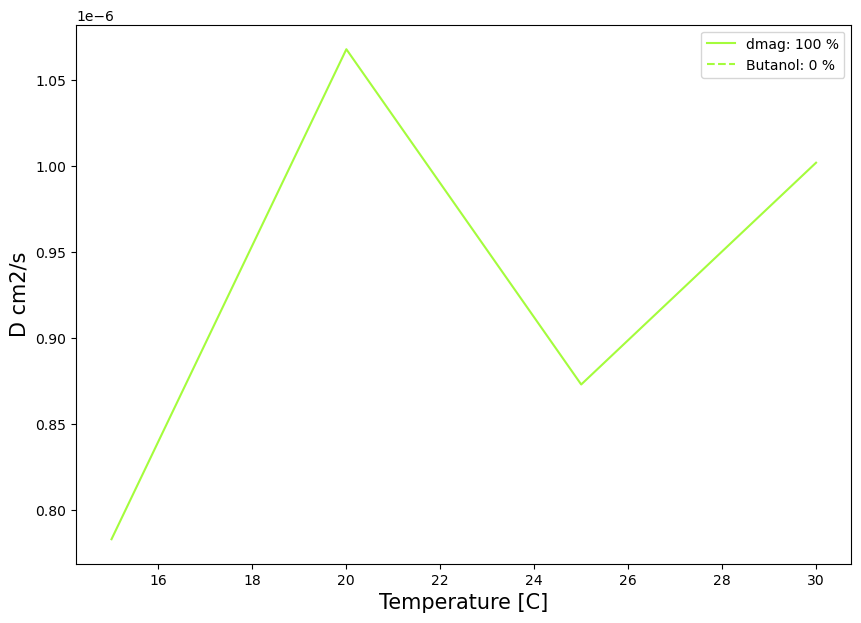

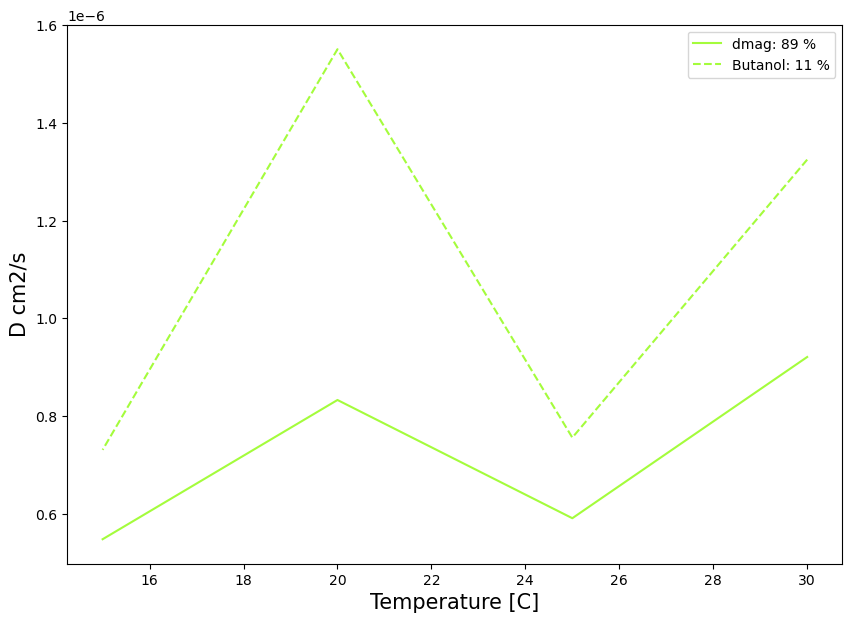

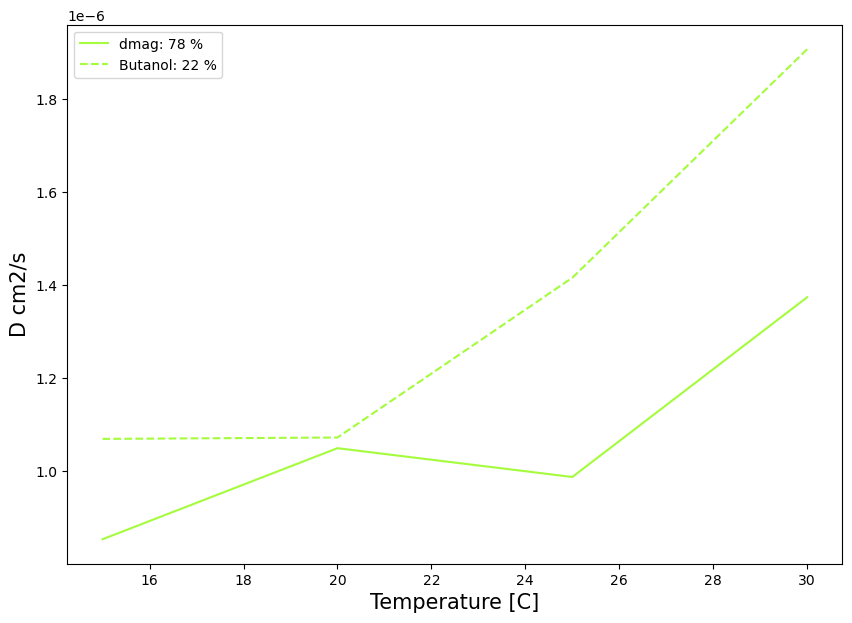

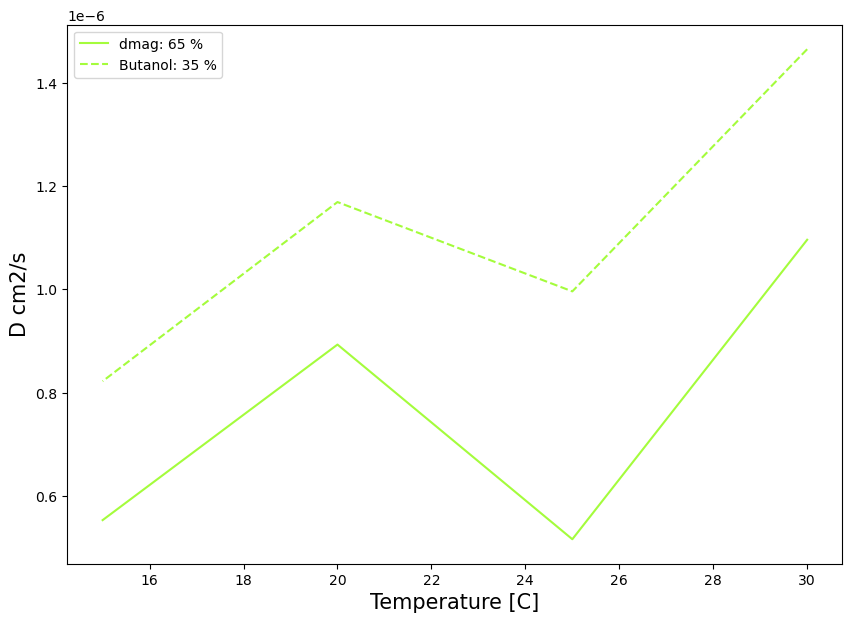

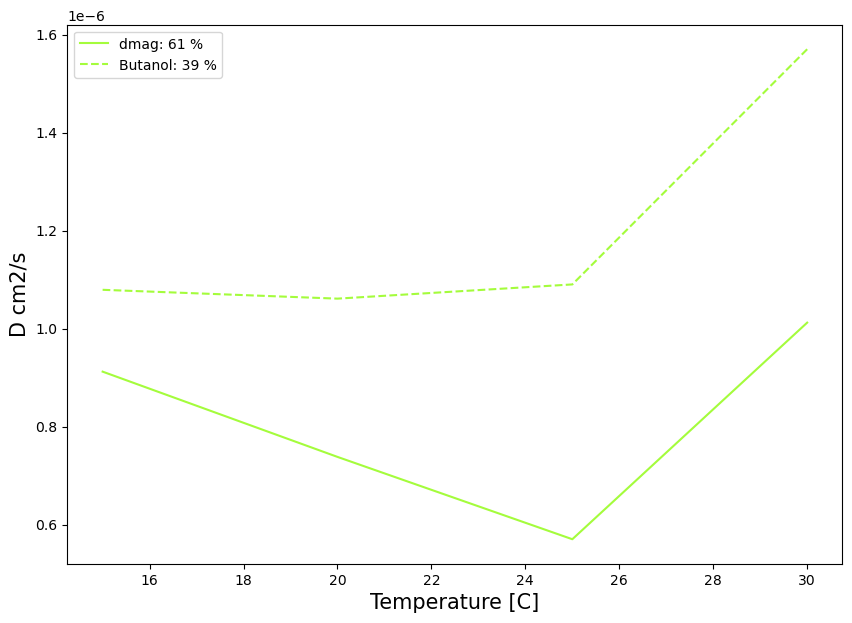

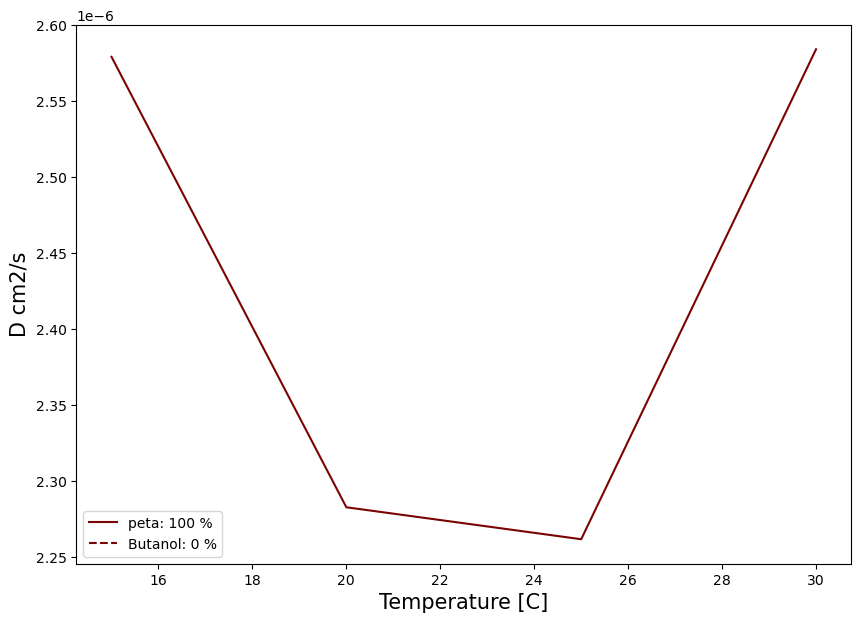

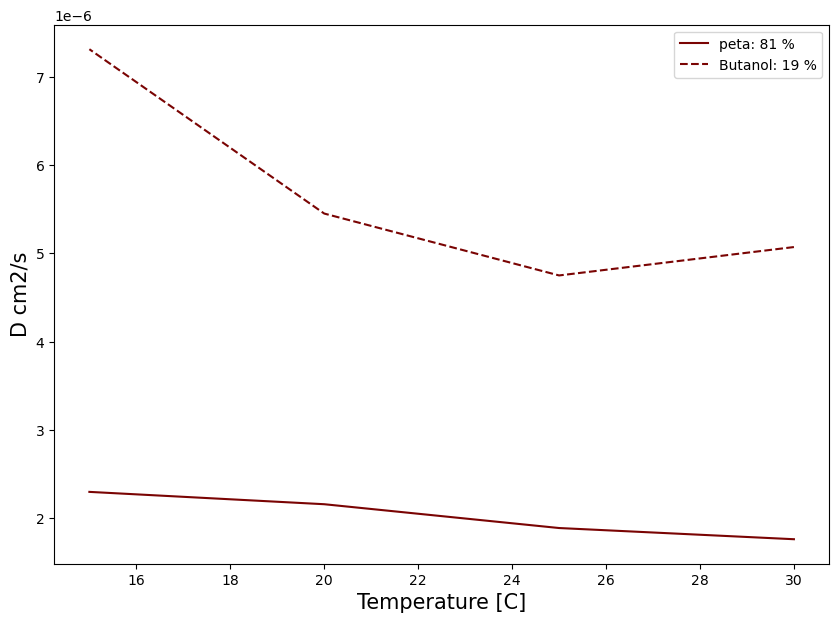

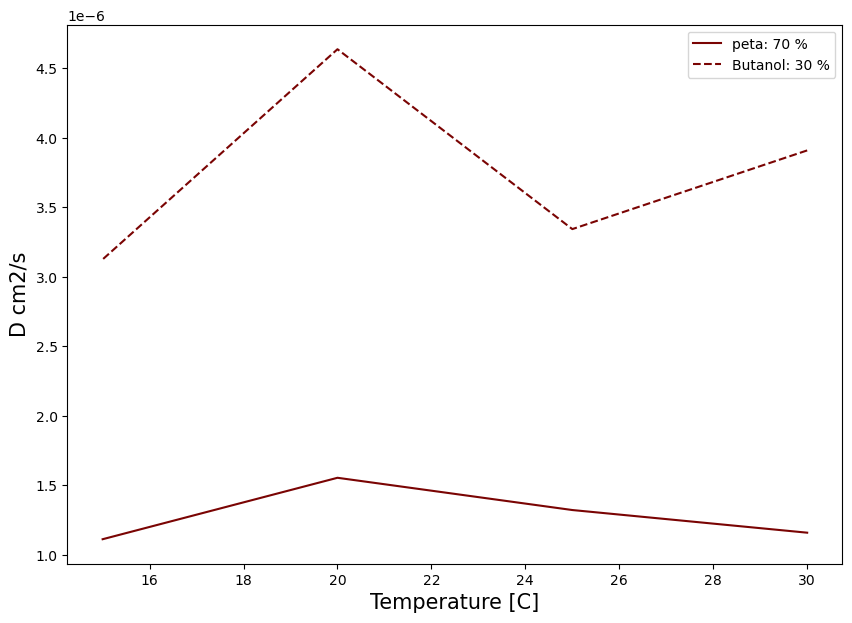

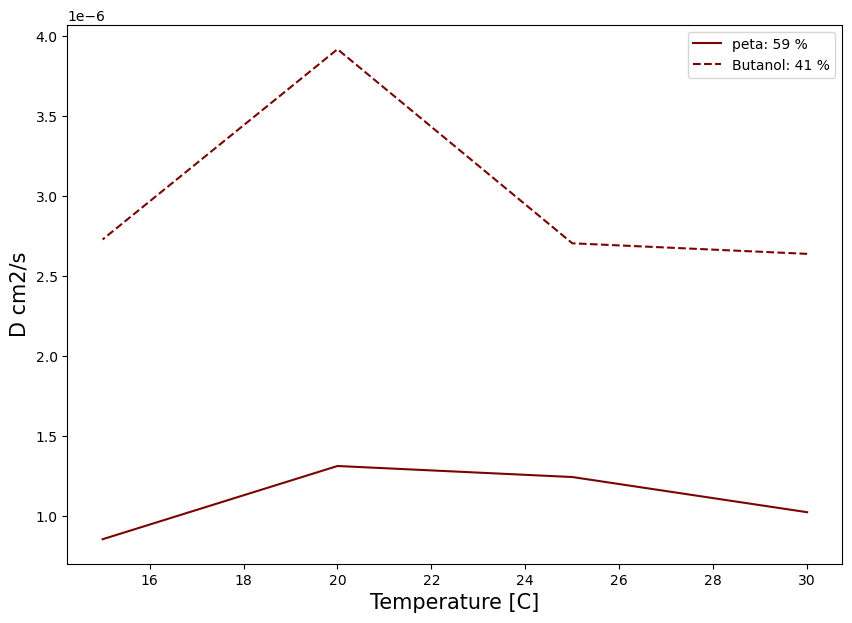

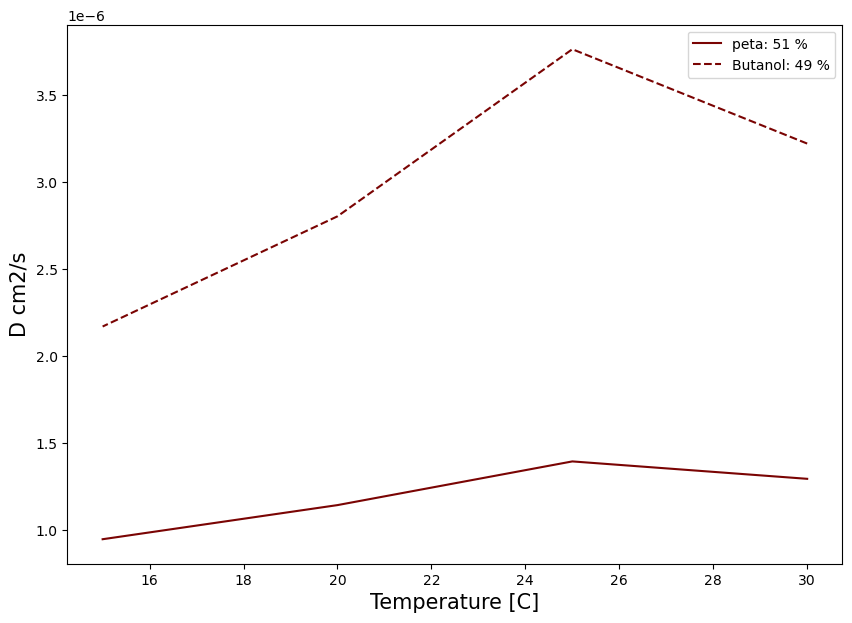

In [18]:
# D
colors_list = mcp.gen_color(
    cmap="turbo",
    n=len(D_df['compound'].unique()),
)
i = 0
for compound in Mols:
    df_sub = D_df[D_df['compound'] == compound.name]
    if len(df_sub) == 0:
        continue

    # fig, ax = plt.subplots(num="DT")

    for [x], df in df_sub.groupby(by=['x']):
        fig, ax = plt.subplots(num="DT")
        data_x = df.sort_values(by=['Temperature'], ascending=False)
        ax.plot(
            data_x['Temperature'],
            data_x['D_comp'],
            label=f"{compound.name}: {100-x} %",
            c=colors_list[i],
        )
        ax.plot(
            data_x['Temperature'],
            data_x['D_but'],
            linestyle='dashed',
            label=f"Butanol: {x} %",
            c=colors_list[i],
        )

        ax.set_xlabel("Temperature [C]")
        ax.set_ylabel("D cm2/s")
        ax.legend()
        plt.show()
    i += 1

# Combine results

In [51]:
D = pd.read_csv(r'gromacs\workspace\res.csv', index_col=0)
V = pd.read_csv(r'vixcosity\results.csv', index_col=0)[
    ['x', 'Temperature', 'rho', 'w_mass', 'w_vol', 'Viscosity', 'compound']
]
V['x'] = V['x'].astype(int)

In [55]:
M=pd.merge(D,V,on=['x','Temperature','compound'],how='inner')


In [56]:
M = M[M['Temperature']!=20]

In [46]:
def calculate_h_comp(r: pd.Series):
    T = r['Temperature']+273
    v = r['Viscosity']
    D_comp = r['D_comp']
    return T / (v * D_comp)


def calculate_h_but(r: pd.Series):
    T = r['Temperature']+273
    v = r['Viscosity']
    D_but = r['D_but']
    return T / (v * D_but) if D_but else 0

M['H_comp']= M.apply(calculate_h_comp,axis=1)
M['H_but']= M.apply(calculate_h_but,axis=1)

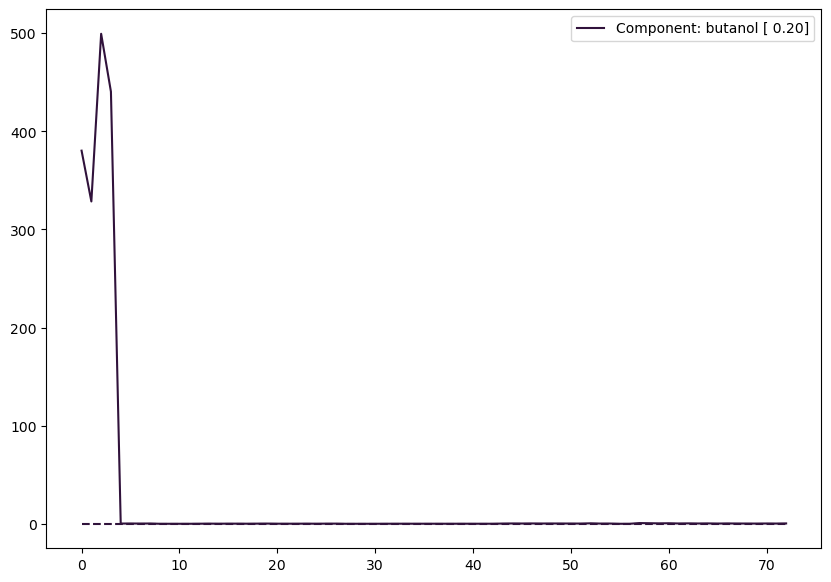

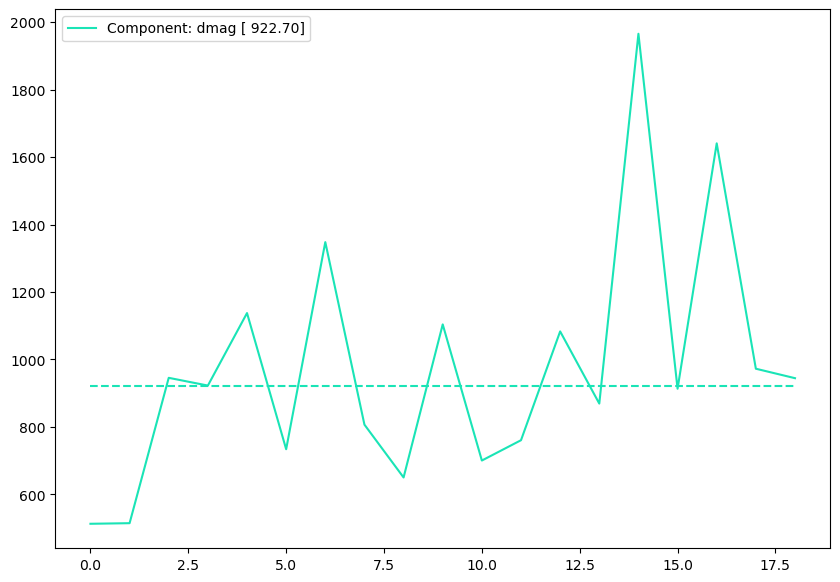

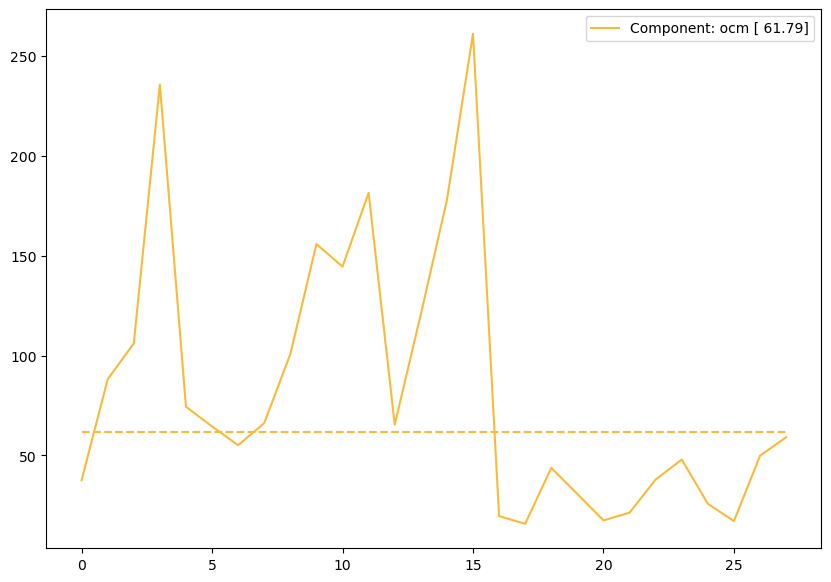

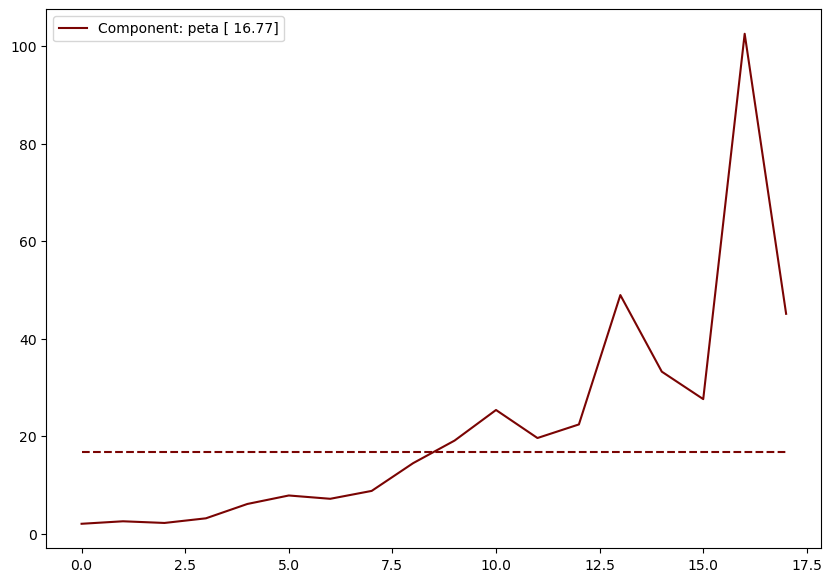

In [48]:
colors_list = mcp.gen_color(
    cmap="turbo",
    n=len(M['compound'].unique()),
)
i = 0
d_dict = {}
for name, group in M.groupby(by='compound'):
    H_comp = np.array(group['H_comp'])
    if name == 'butanol':
        H_but = np.array(M['D_but'])
        H_comp = np.array([*H_comp, *H_but])[:]

    H0 = np.median(H_comp)
    d_dict[name] = H0
    fig, ax = plt.subplots(num="H")
    ax.plot(
        H_comp,
        c=colors_list[i],
        label=f"Component: {name} [{H0: .2f}]",
    )
    ax.plot(
        [H0] * len(H_comp),
        c=colors_list[i],
        linestyle='dashed',
    )
    ax.legend()
    plt.show()
    i += 1

In [40]:
d_dict

{'butanol': 0.15069447094171534,
 'dmag': 75.35637065465117,
 'ocm': 4.0263121776834545,
 'peta': 1.2666302904165525}

In [42]:
def calculate_D(r):
    v = r['Viscosity']
    T = r['Temperature']+273
    comp = r['compound']
    h = d_dict[comp]
    return T / v / h


def calculate_D_but(r):
    v = r['Viscosity']
    T = r['Temperature']+273
    h = d_dict['butanol']
    return T / v / h

M['D_comp0']=M['D_comp']
M['D_comp'] = M.apply(calculate_D, axis=1)
M['D_but0']=M['D_but']
M['D_but'] = M.apply(calculate_D_but, axis=1)
M